# Hotel Booking Demand

> [Data Source](https://www.kaggle.com/jessemostipak/hotel-booking-demand)

## Import

In [1]:
import graphviz
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree, export_text

In [2]:
df = pd.read_csv("hotel_bookings.csv")

In [3]:
COLOR = ["#08ffc8", "#fff7f7", "#dadada", "#204969"]
COLOR = ["#ffb6b9", "#fae3d9", "#bbded6", "#8ac6d1"]
COLOR = ["#416C77"]
STYLES = {
    "figsize": (50, 30),
    "fontsize": 50,
    "width": 0.9,
    "color": COLOR
}

## Preview

In [4]:
df.shape

(119390, 32)

In [5]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [6]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

## Pre Processing

In [7]:
def columns_drop(df, columns):
    for col_name in columns:
        df.drop(col_name, axis=1, inplace=True)
def columns_fill_distribution(df, columns):
    for col_name in columns:
        distribution = df[col_name].value_counts(normalize=True)
        missing = df[col_name].isnull()
        df.loc[missing, col_name] = np.random.choice(distribution.index, size=len(df[missing]), p=distribution.values)
def columns_to_boolean(df, columns):
    for col_name in columns:
        df[col_name] = df[col_name].astype("bool")
def columns_to_month_int(df, columns):
    MONTH_MAP = {"January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6, "July": 7, "August": 8, "September": 9, "October": 10, "November": 11, "December": 12}
    for col_name in columns:
        df[col_name] = df[col_name].map(MONTH_MAP)
def columns_to_datetime(df, columns):
    for col_name in columns:
        df[col_name] = pd.to_datetime(df[col_name])
def columns_to_timedelta_day(df, columns):
    for col_name in columns:
        df[col_name] = pd.to_timedelta(df[col_name], unit="day")
def columns_to_one_hot_boolean(df, columns):
    for col_name in columns:
        df = pd.concat([df, pd.get_dummies(df[col_name], prefix=col_name, dtype=np.bool)],axis=1)
        df.drop(col_name, axis=1, inplace=True)
    return df
def custom_date_combine(df):
    df["arrival_date"] = pd.to_datetime(df[[
        "arrival_date_year",
        "arrival_date_month",
        "arrival_date_day_of_month"
    ]].rename(columns={
        "arrival_date_year": "Year",
        "arrival_date_month": "Month",
        "arrival_date_day_of_month": "Day"
    }))

In [8]:
to_drop = ["company", "agent", "market_segment", "distribution_channel"]
to_fill = ["children", "meal", "country"]
to_bool = ["is_canceled", "is_repeated_guest"]
to_month_int = ["arrival_date_month"]
to_datetime = ["reservation_status_date"]
to_timedelta_day = ["lead_time"]
to_one_hot = ["hotel", "meal", "deposit_type", "customer_type", "reservation_status", "assigned_room_type", "reserved_room_type"]

In [9]:
df.replace("Undefined", np.NaN, inplace=True)
# Drop unnecessary columns
columns_drop(df, to_drop)
# Fill null randomly with distribution
columns_fill_distribution(df, to_fill)
# Convert to boolean
columns_to_boolean(df, to_bool)
# Convert literal month to integer
columns_to_month_int(df, to_month_int)
# Convert to datetime
columns_to_datetime(df, to_datetime)
# Convert to timedelta with precision to day
# columns_to_timedelta_day(df, to_timedelta_day)
# Convert to seperate boolean columns
df = columns_to_one_hot_boolean(df, to_one_hot)
# Apply combination on arrival date
custom_date_combine(df)

In [10]:
df.isnull().sum()

is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
country                           0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
booking_changes                   0
days_in_waiting_list              0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status_date           0
hotel_City Hotel                  0
hotel_Resort Hotel                0
meal_BB                           0
meal_FB                           0
meal_HB                           0
meal_SC                           0
deposit_type_No Deposit     

## Visualize Data Origin
* Data is mostly Europe-oriented

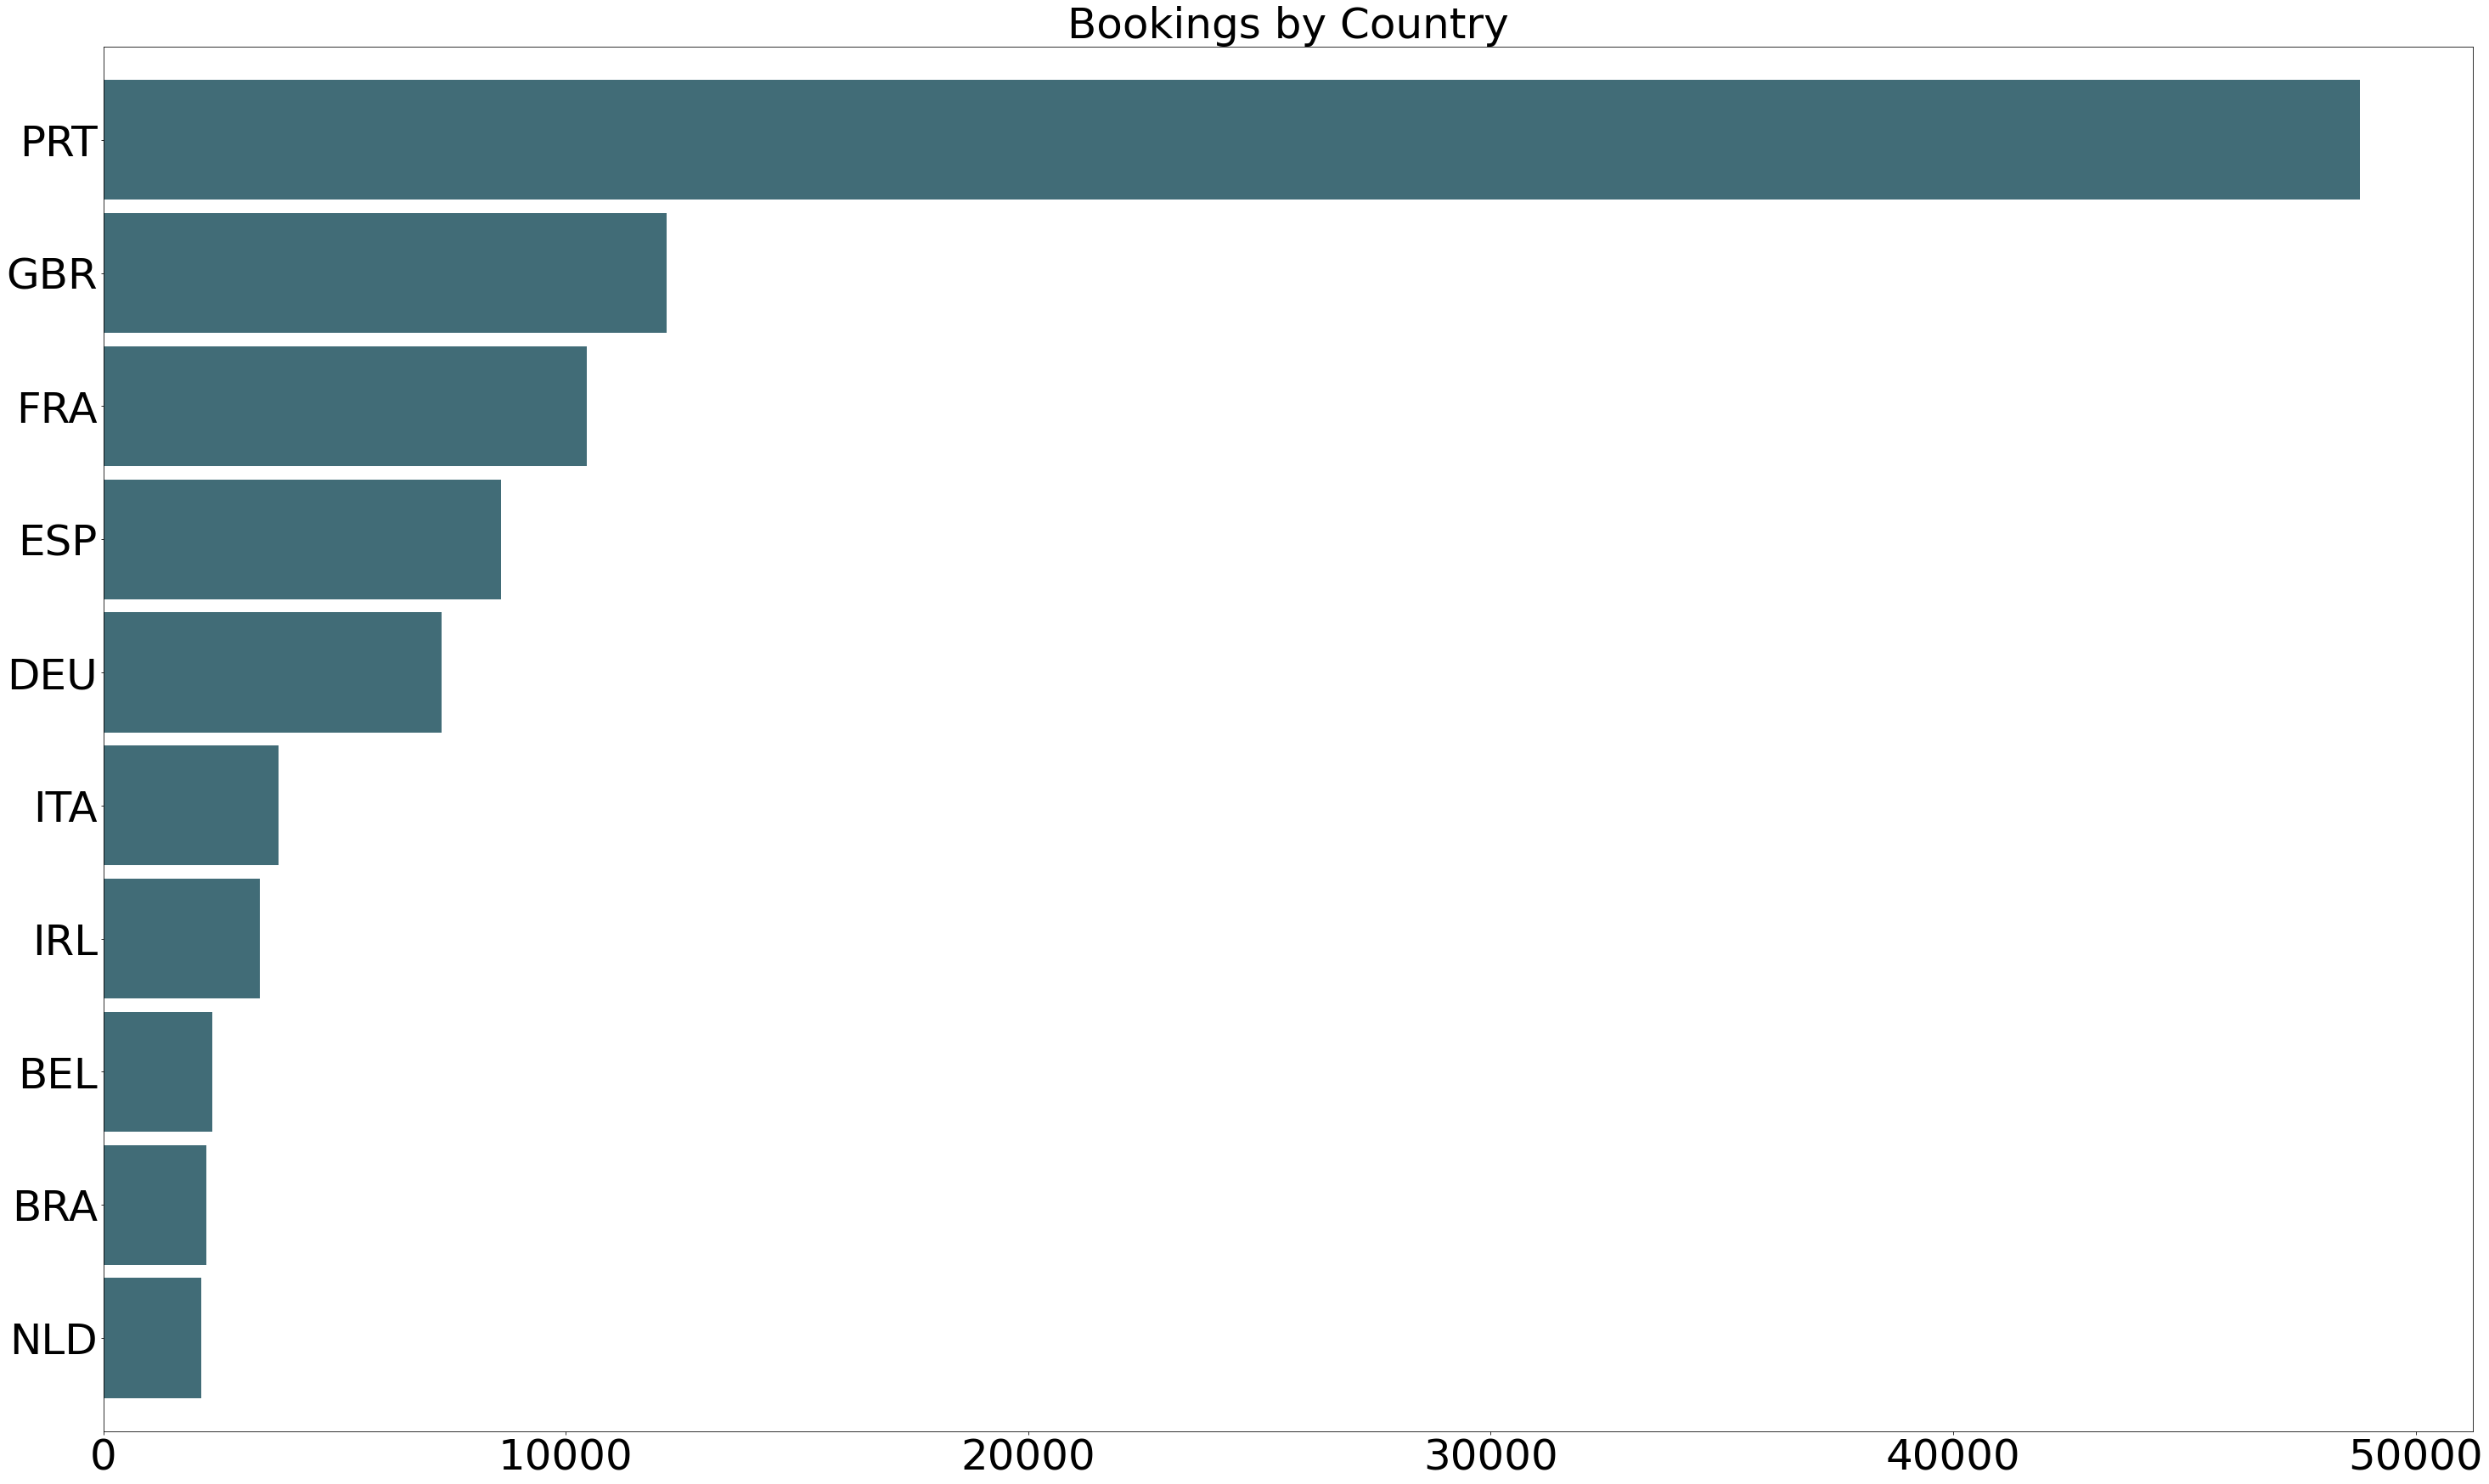

In [11]:
ax = df["country"] \
    .value_counts() \
    .nlargest(n=10) \
    .sort_values() \
    .plot(kind="barh", title="Bookings by Country", **STYLES)
ax.title.set_size(50)

## Visualize Arrival Date Distribution

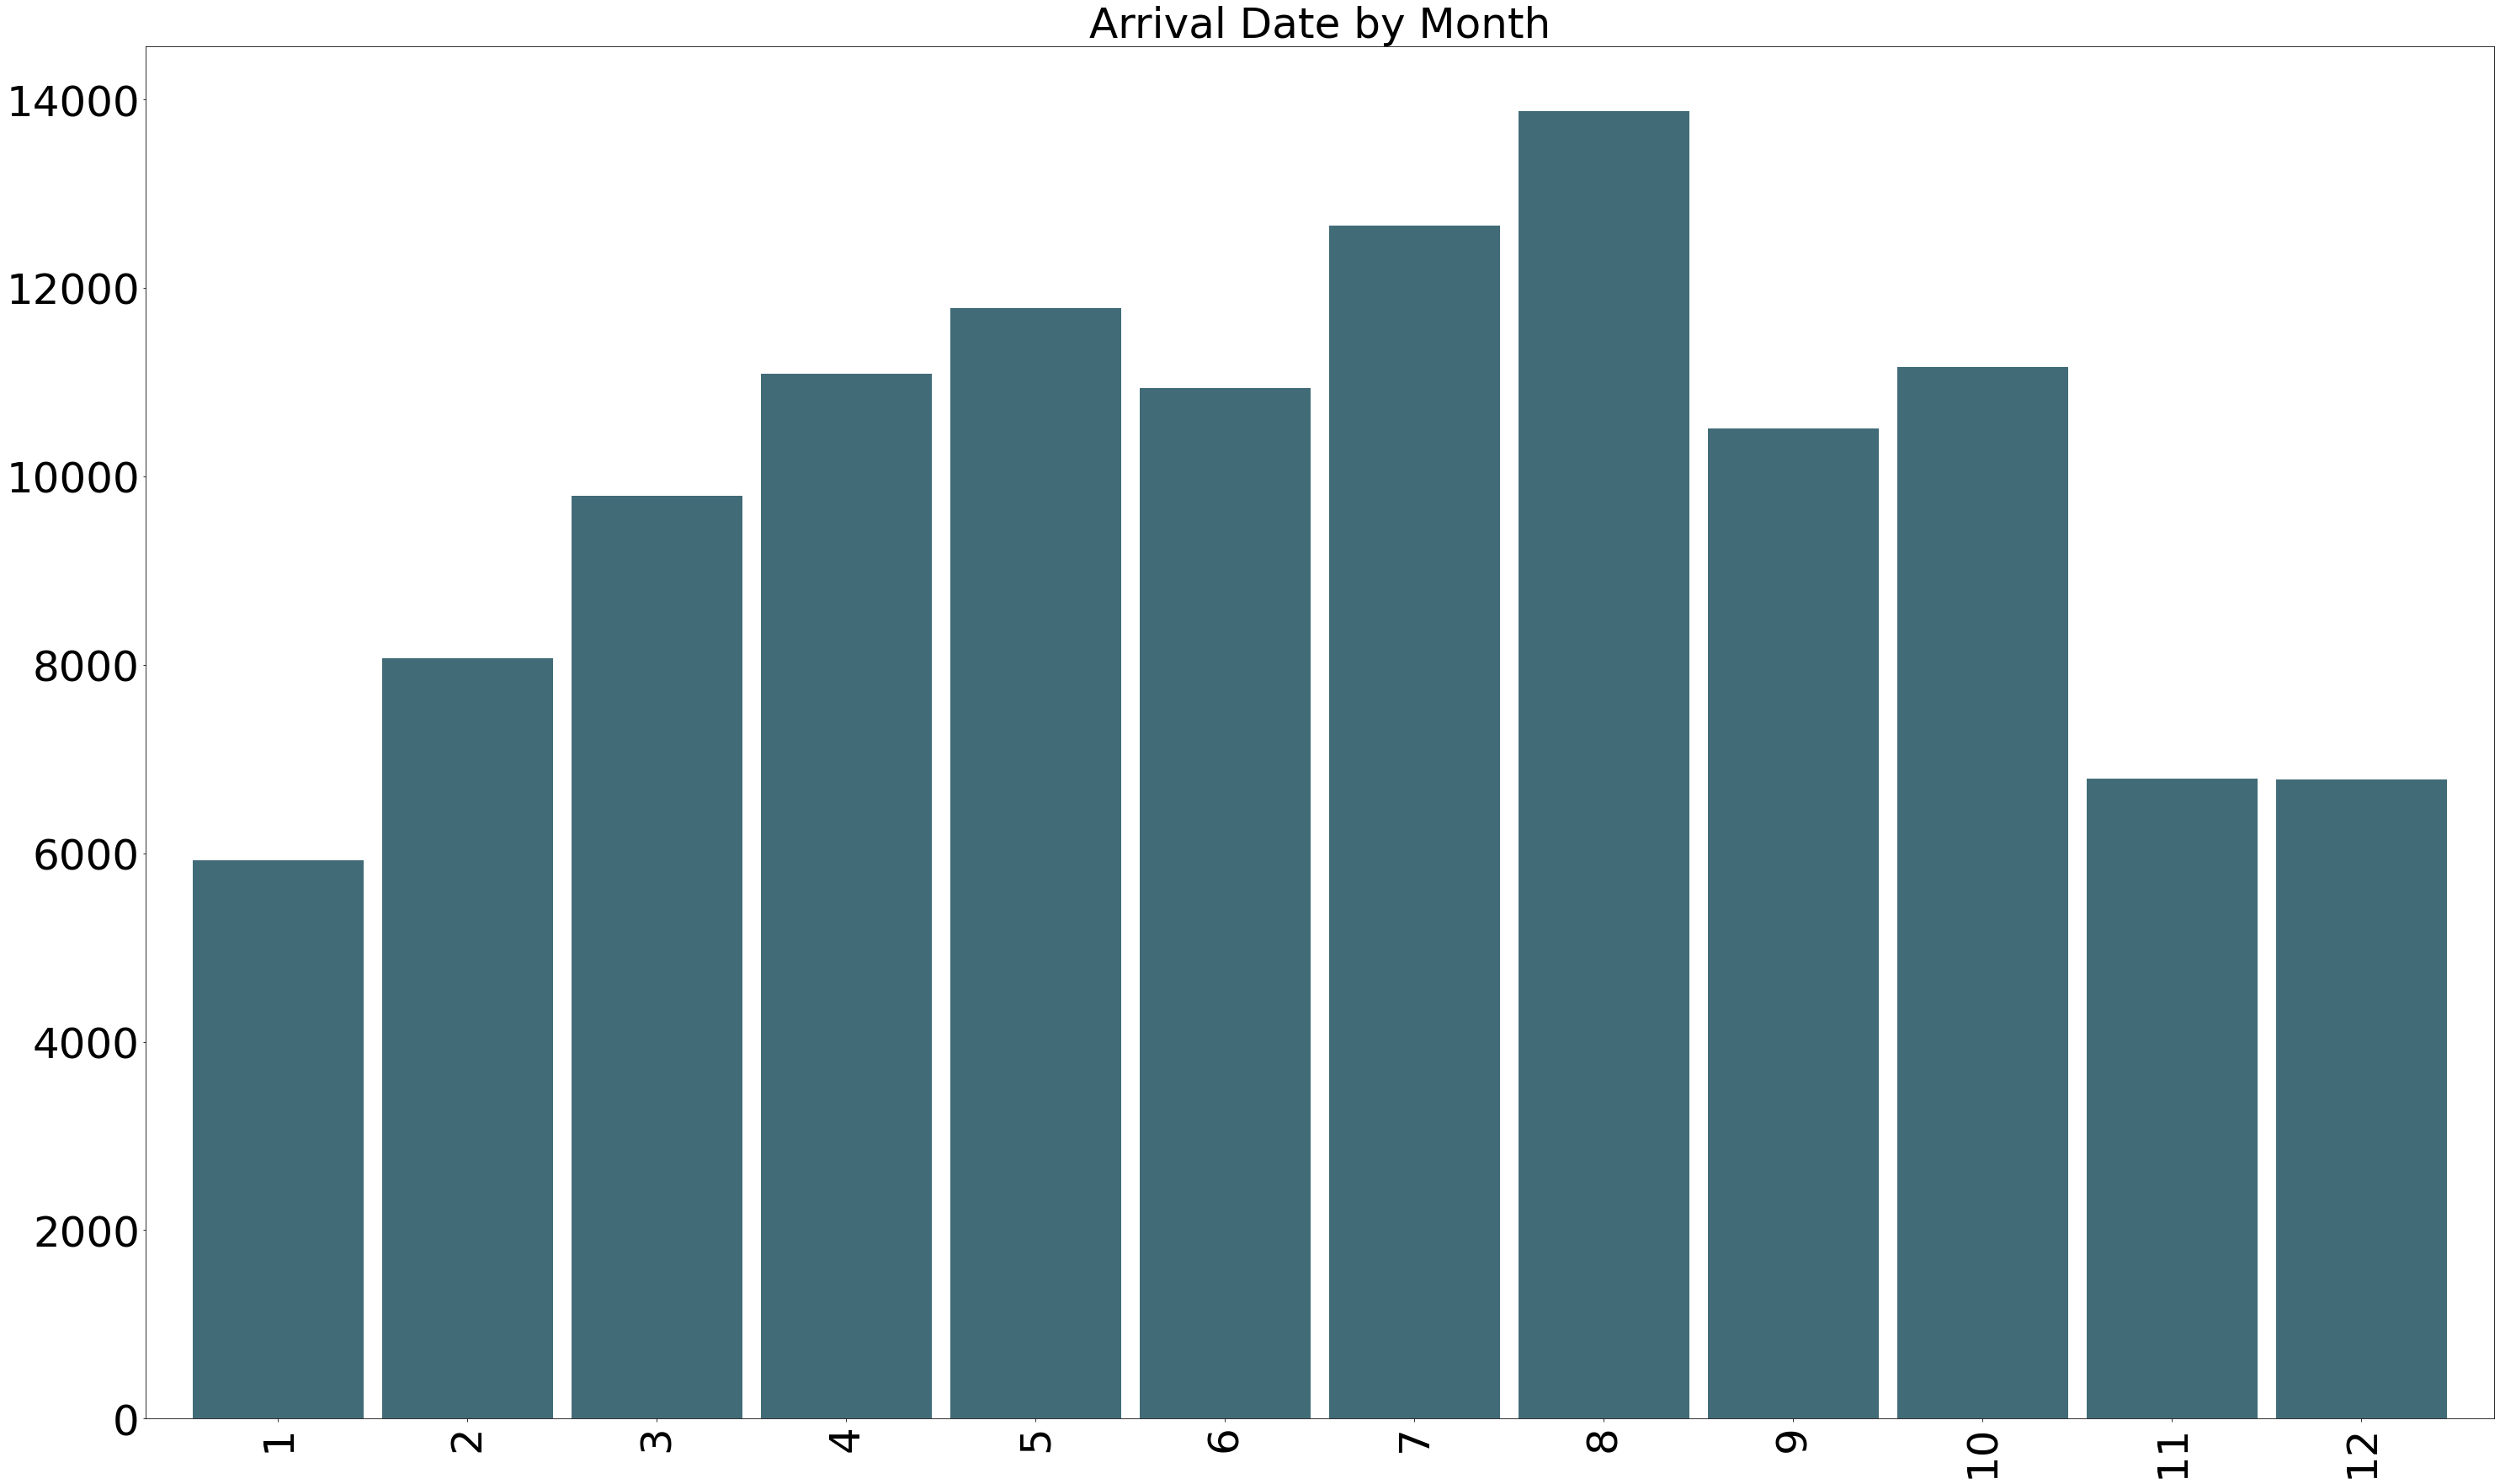

In [12]:
# All Data
ax = df["arrival_date_month"] \
    .value_counts() \
    .sort_index(ascending=True) \
    .plot(kind="bar", title="Arrival Date by Month", **STYLES)
ax.title.set_size(50)

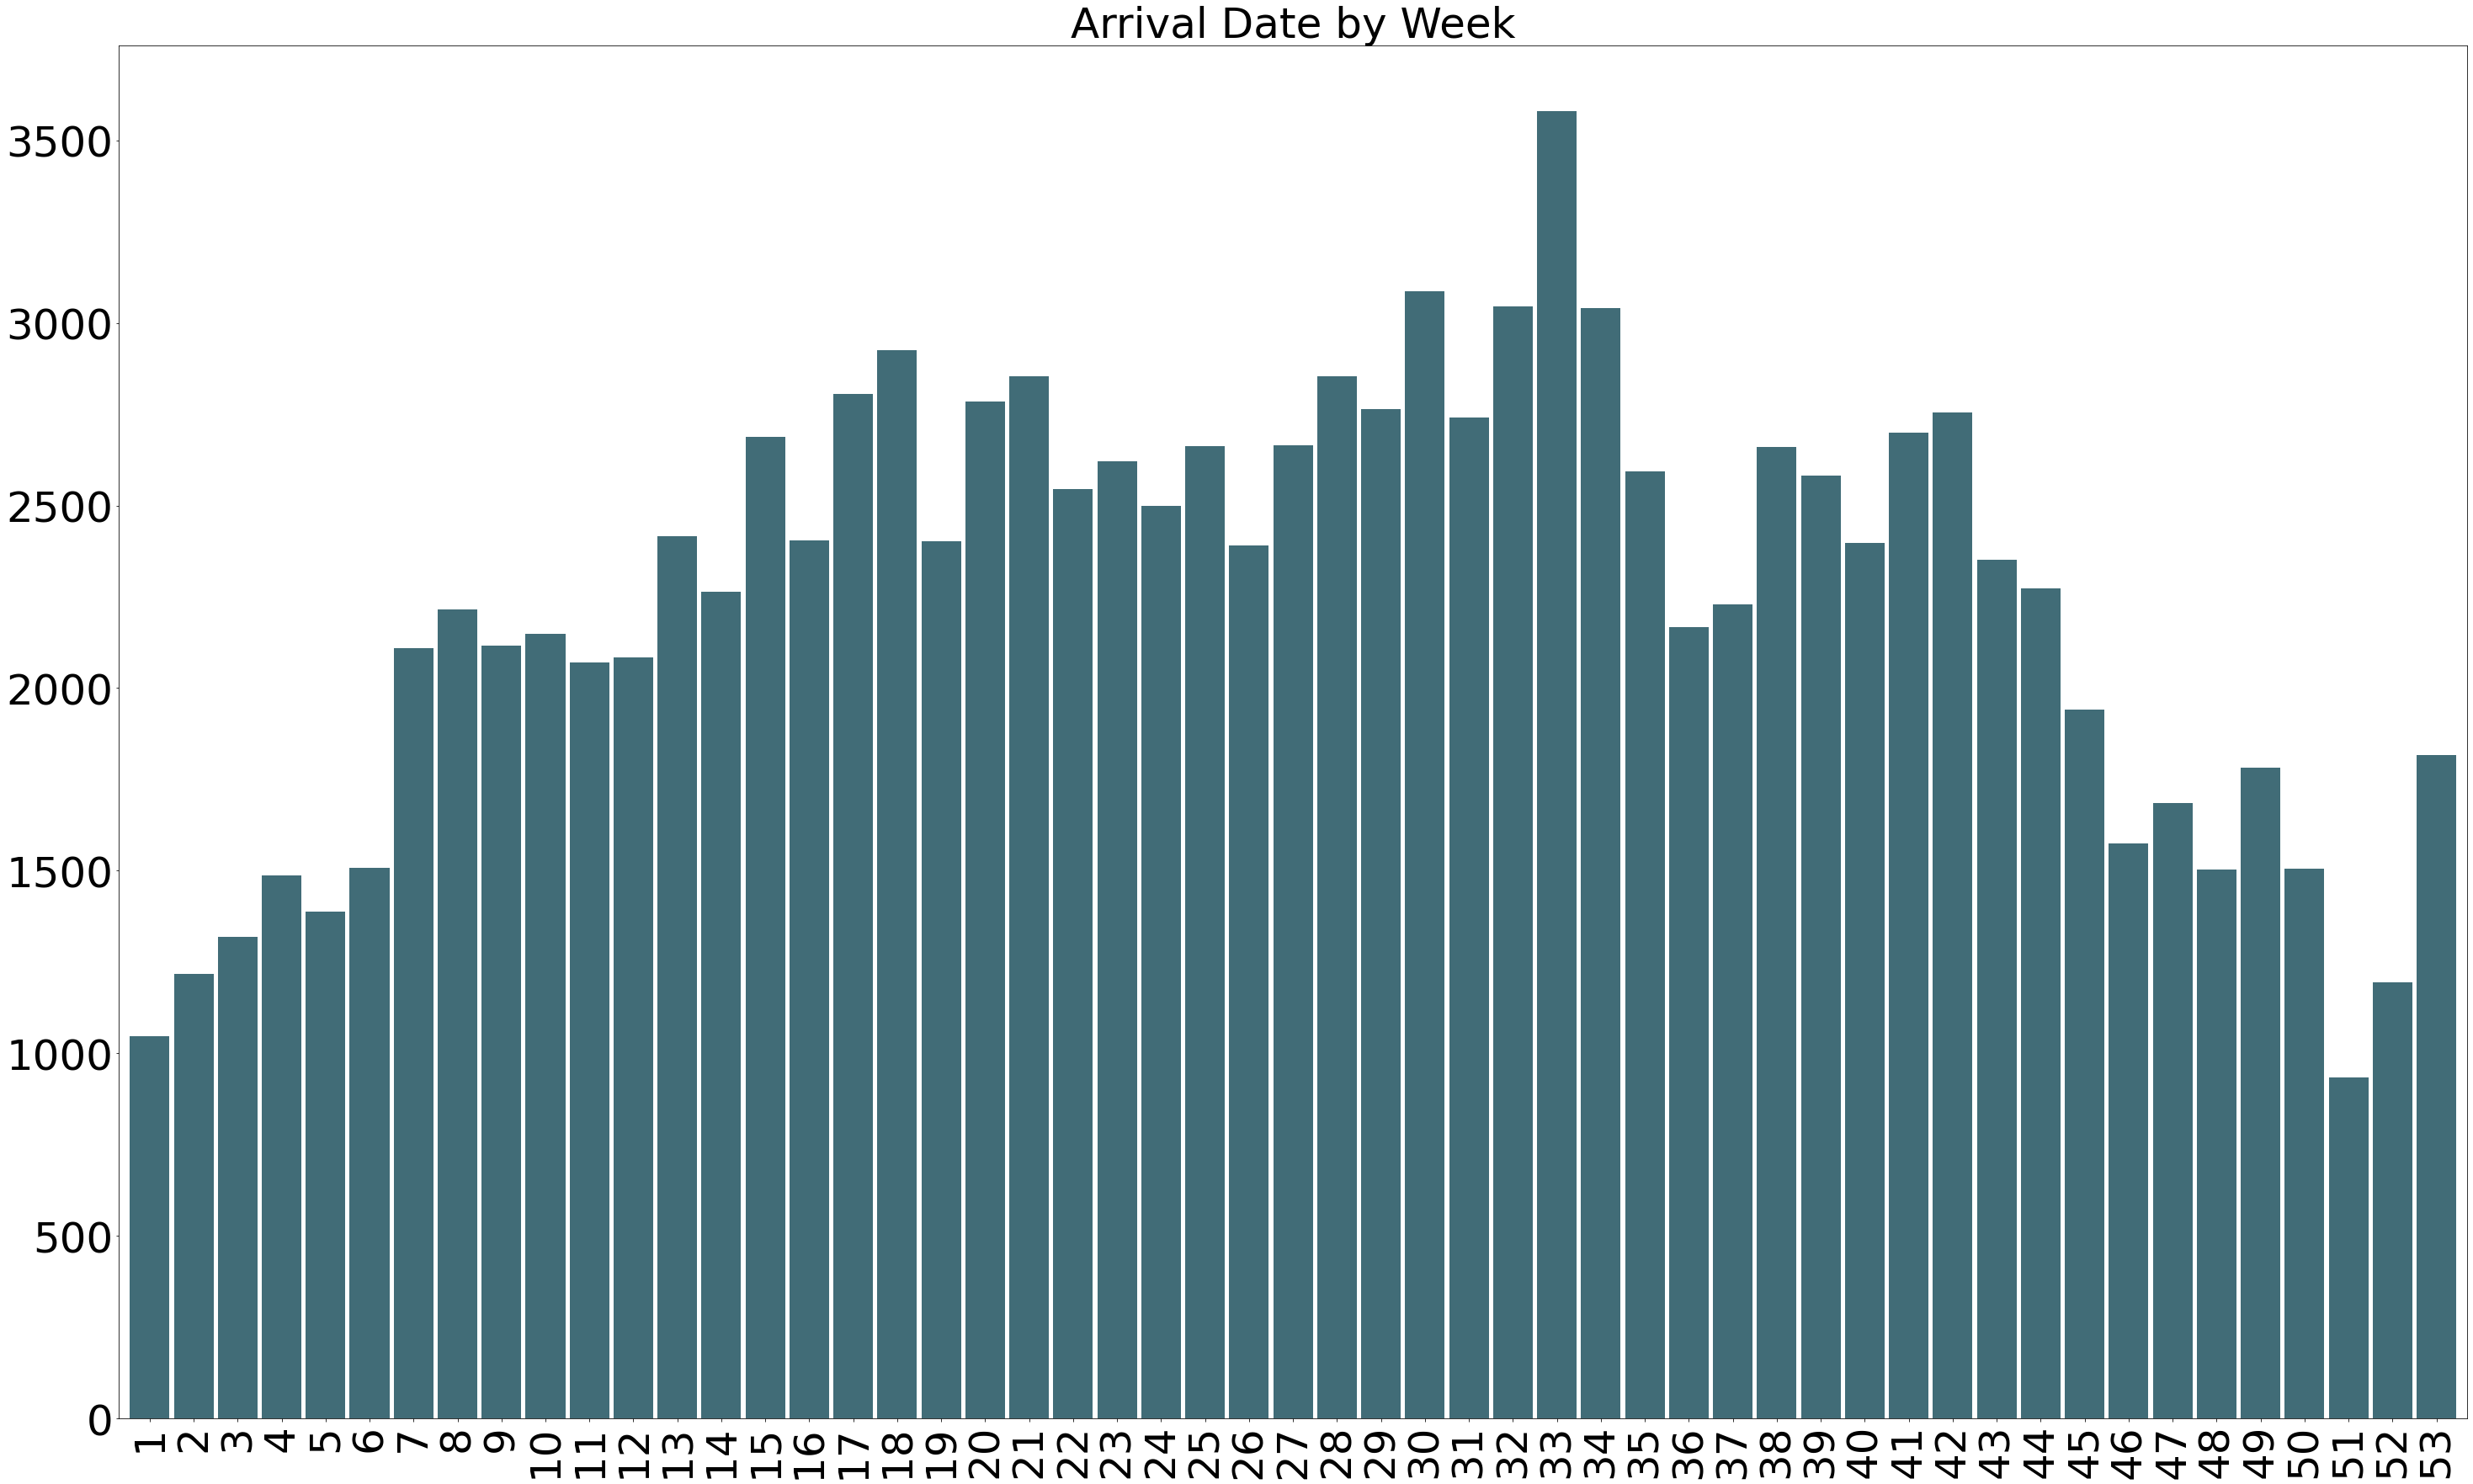

In [13]:
# All Data
ax = df["arrival_date_week_number"] \
    .value_counts() \
    .sort_index(ascending=True) \
    .plot(kind="bar", title="Arrival Date by Week", **STYLES)
ax.title.set_size(50)

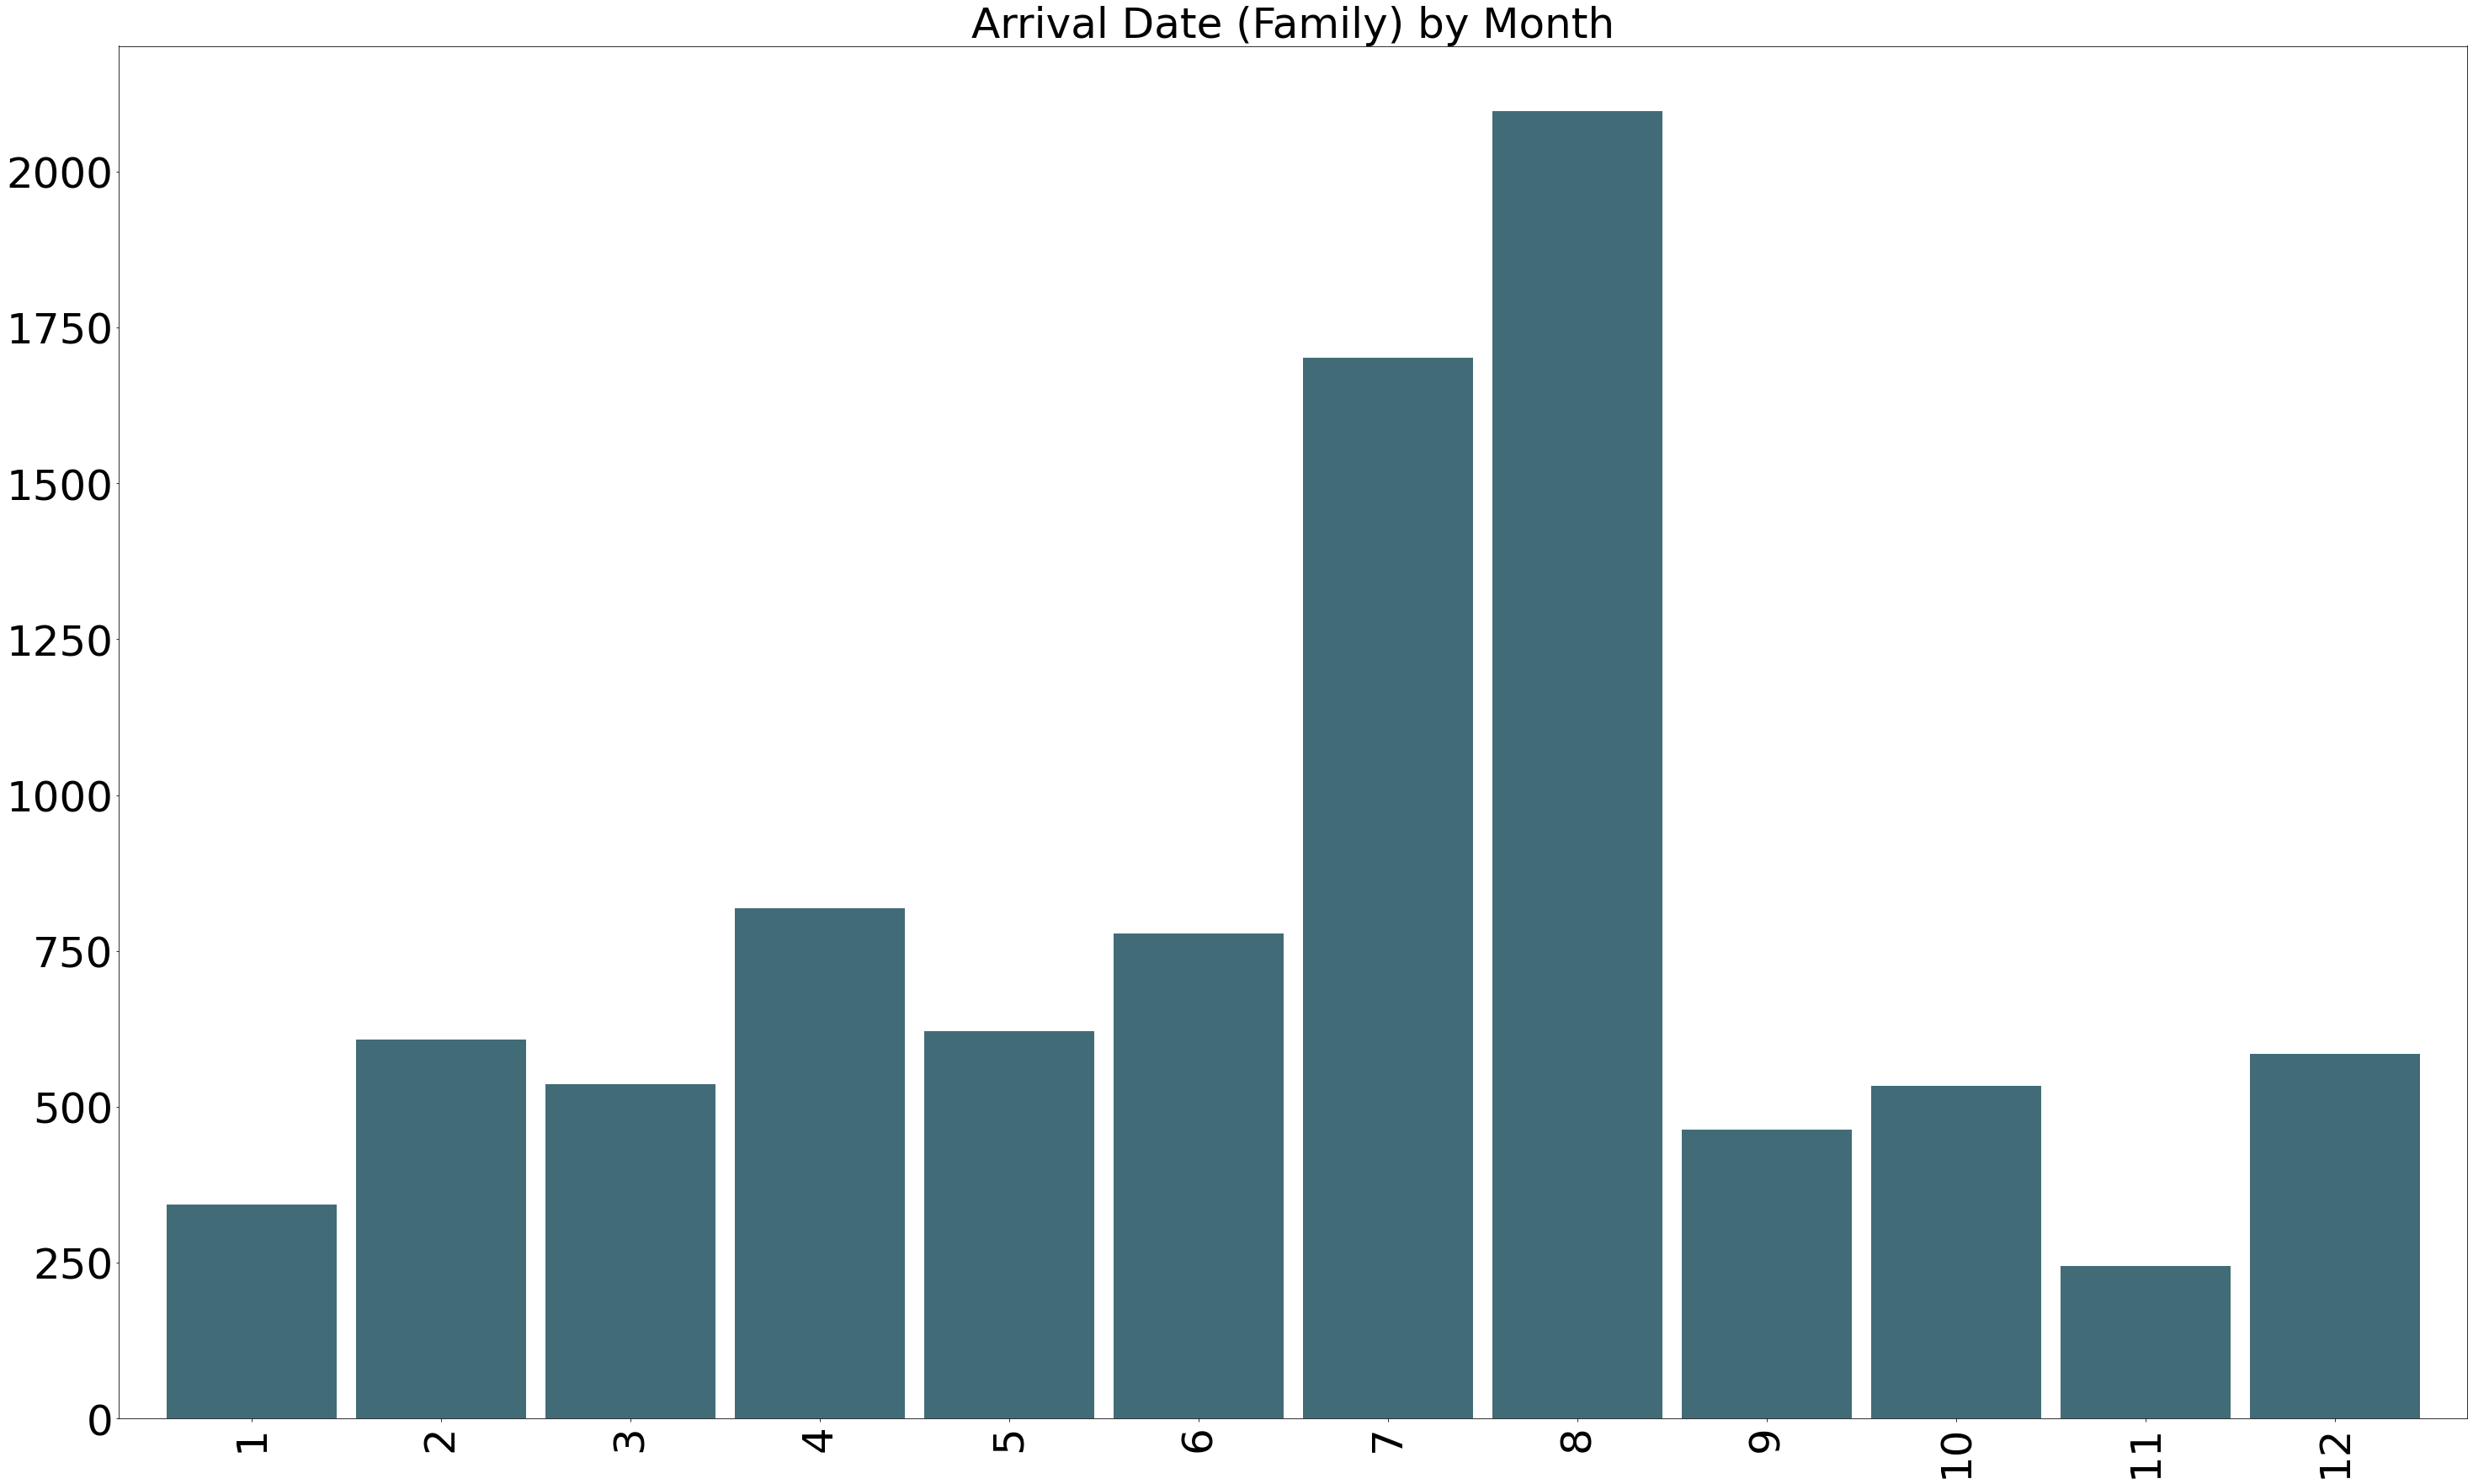

In [14]:
# Family (with any children or babies)
ax = df.loc[(df["children"] > 0) | (df["babies"] > 0)]["arrival_date_month"] \
    .value_counts() \
    .sort_index(ascending=True) \
    .plot(kind="bar", title="Arrival Date (Family) by Month", **STYLES)
ax.title.set_size(50)

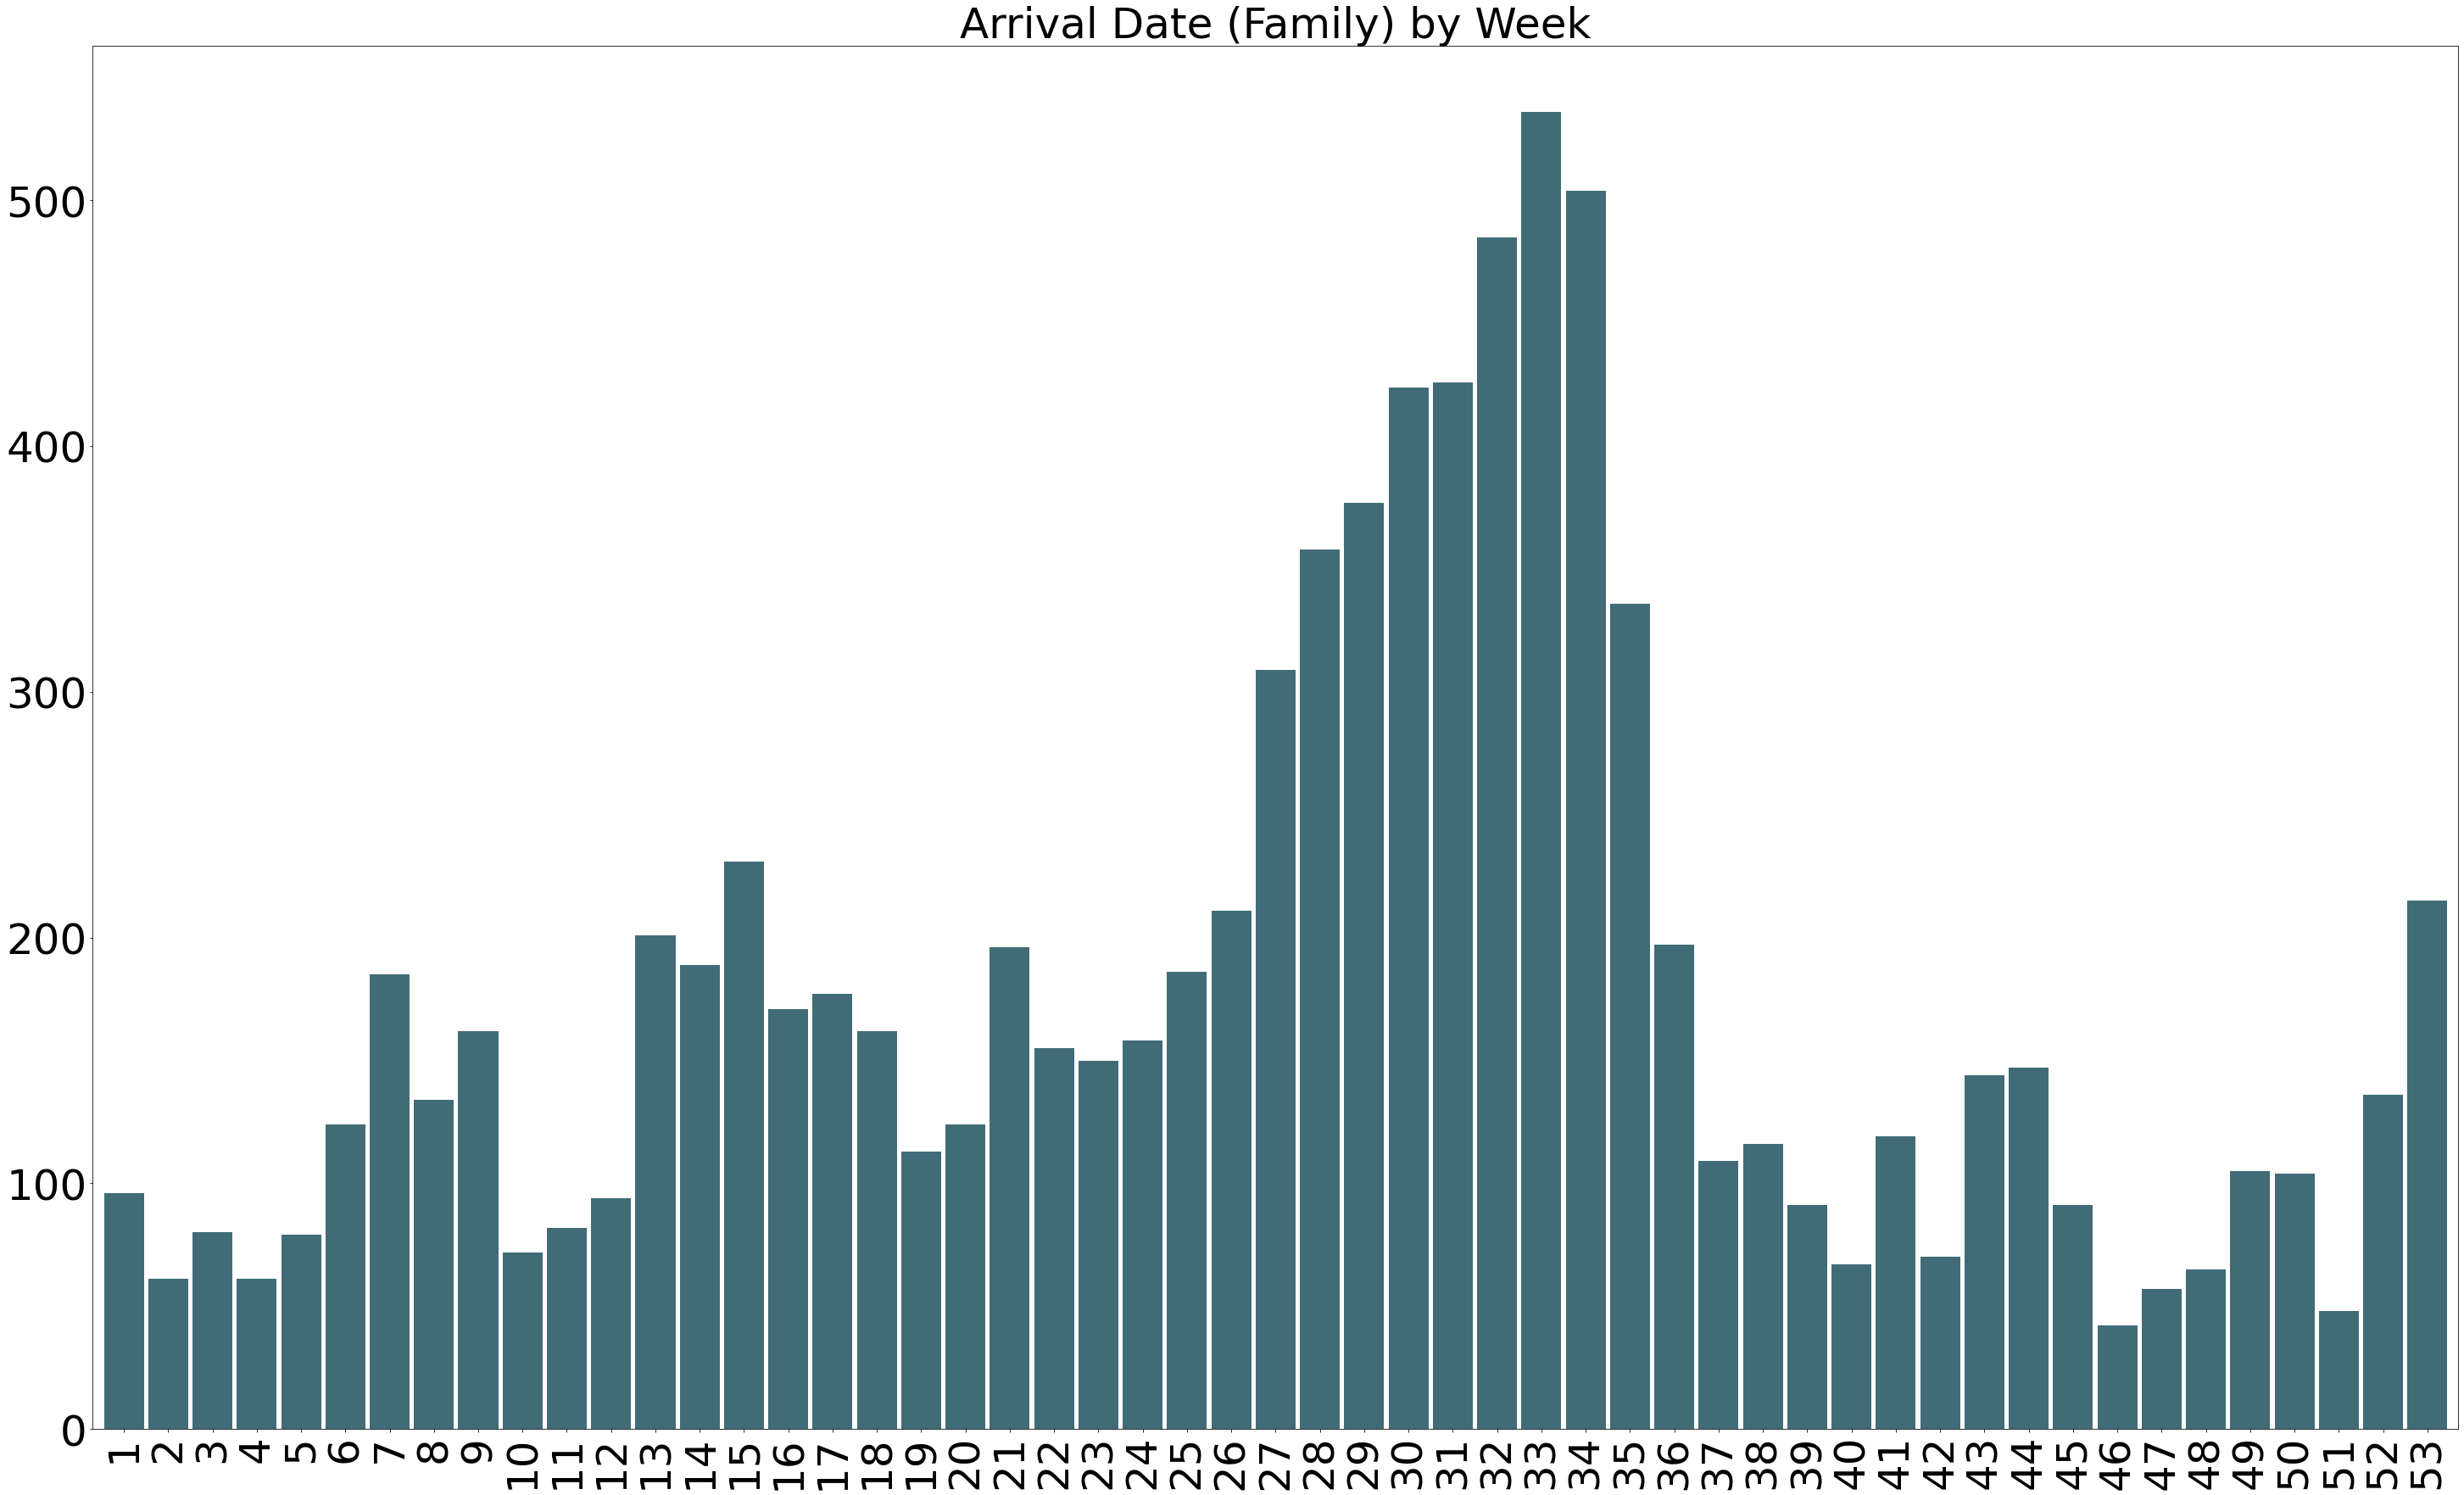

In [15]:
# Family (with any children or babies)
ax = df.loc[(df["children"] > 0) | (df["babies"] > 0)]["arrival_date_week_number"] \
    .value_counts() \
    .sort_index(ascending=True) \
    .plot(kind="bar", title="Arrival Date (Family) by Week", **STYLES)
ax.title.set_size(50)

## Canceled or No-Show bookings

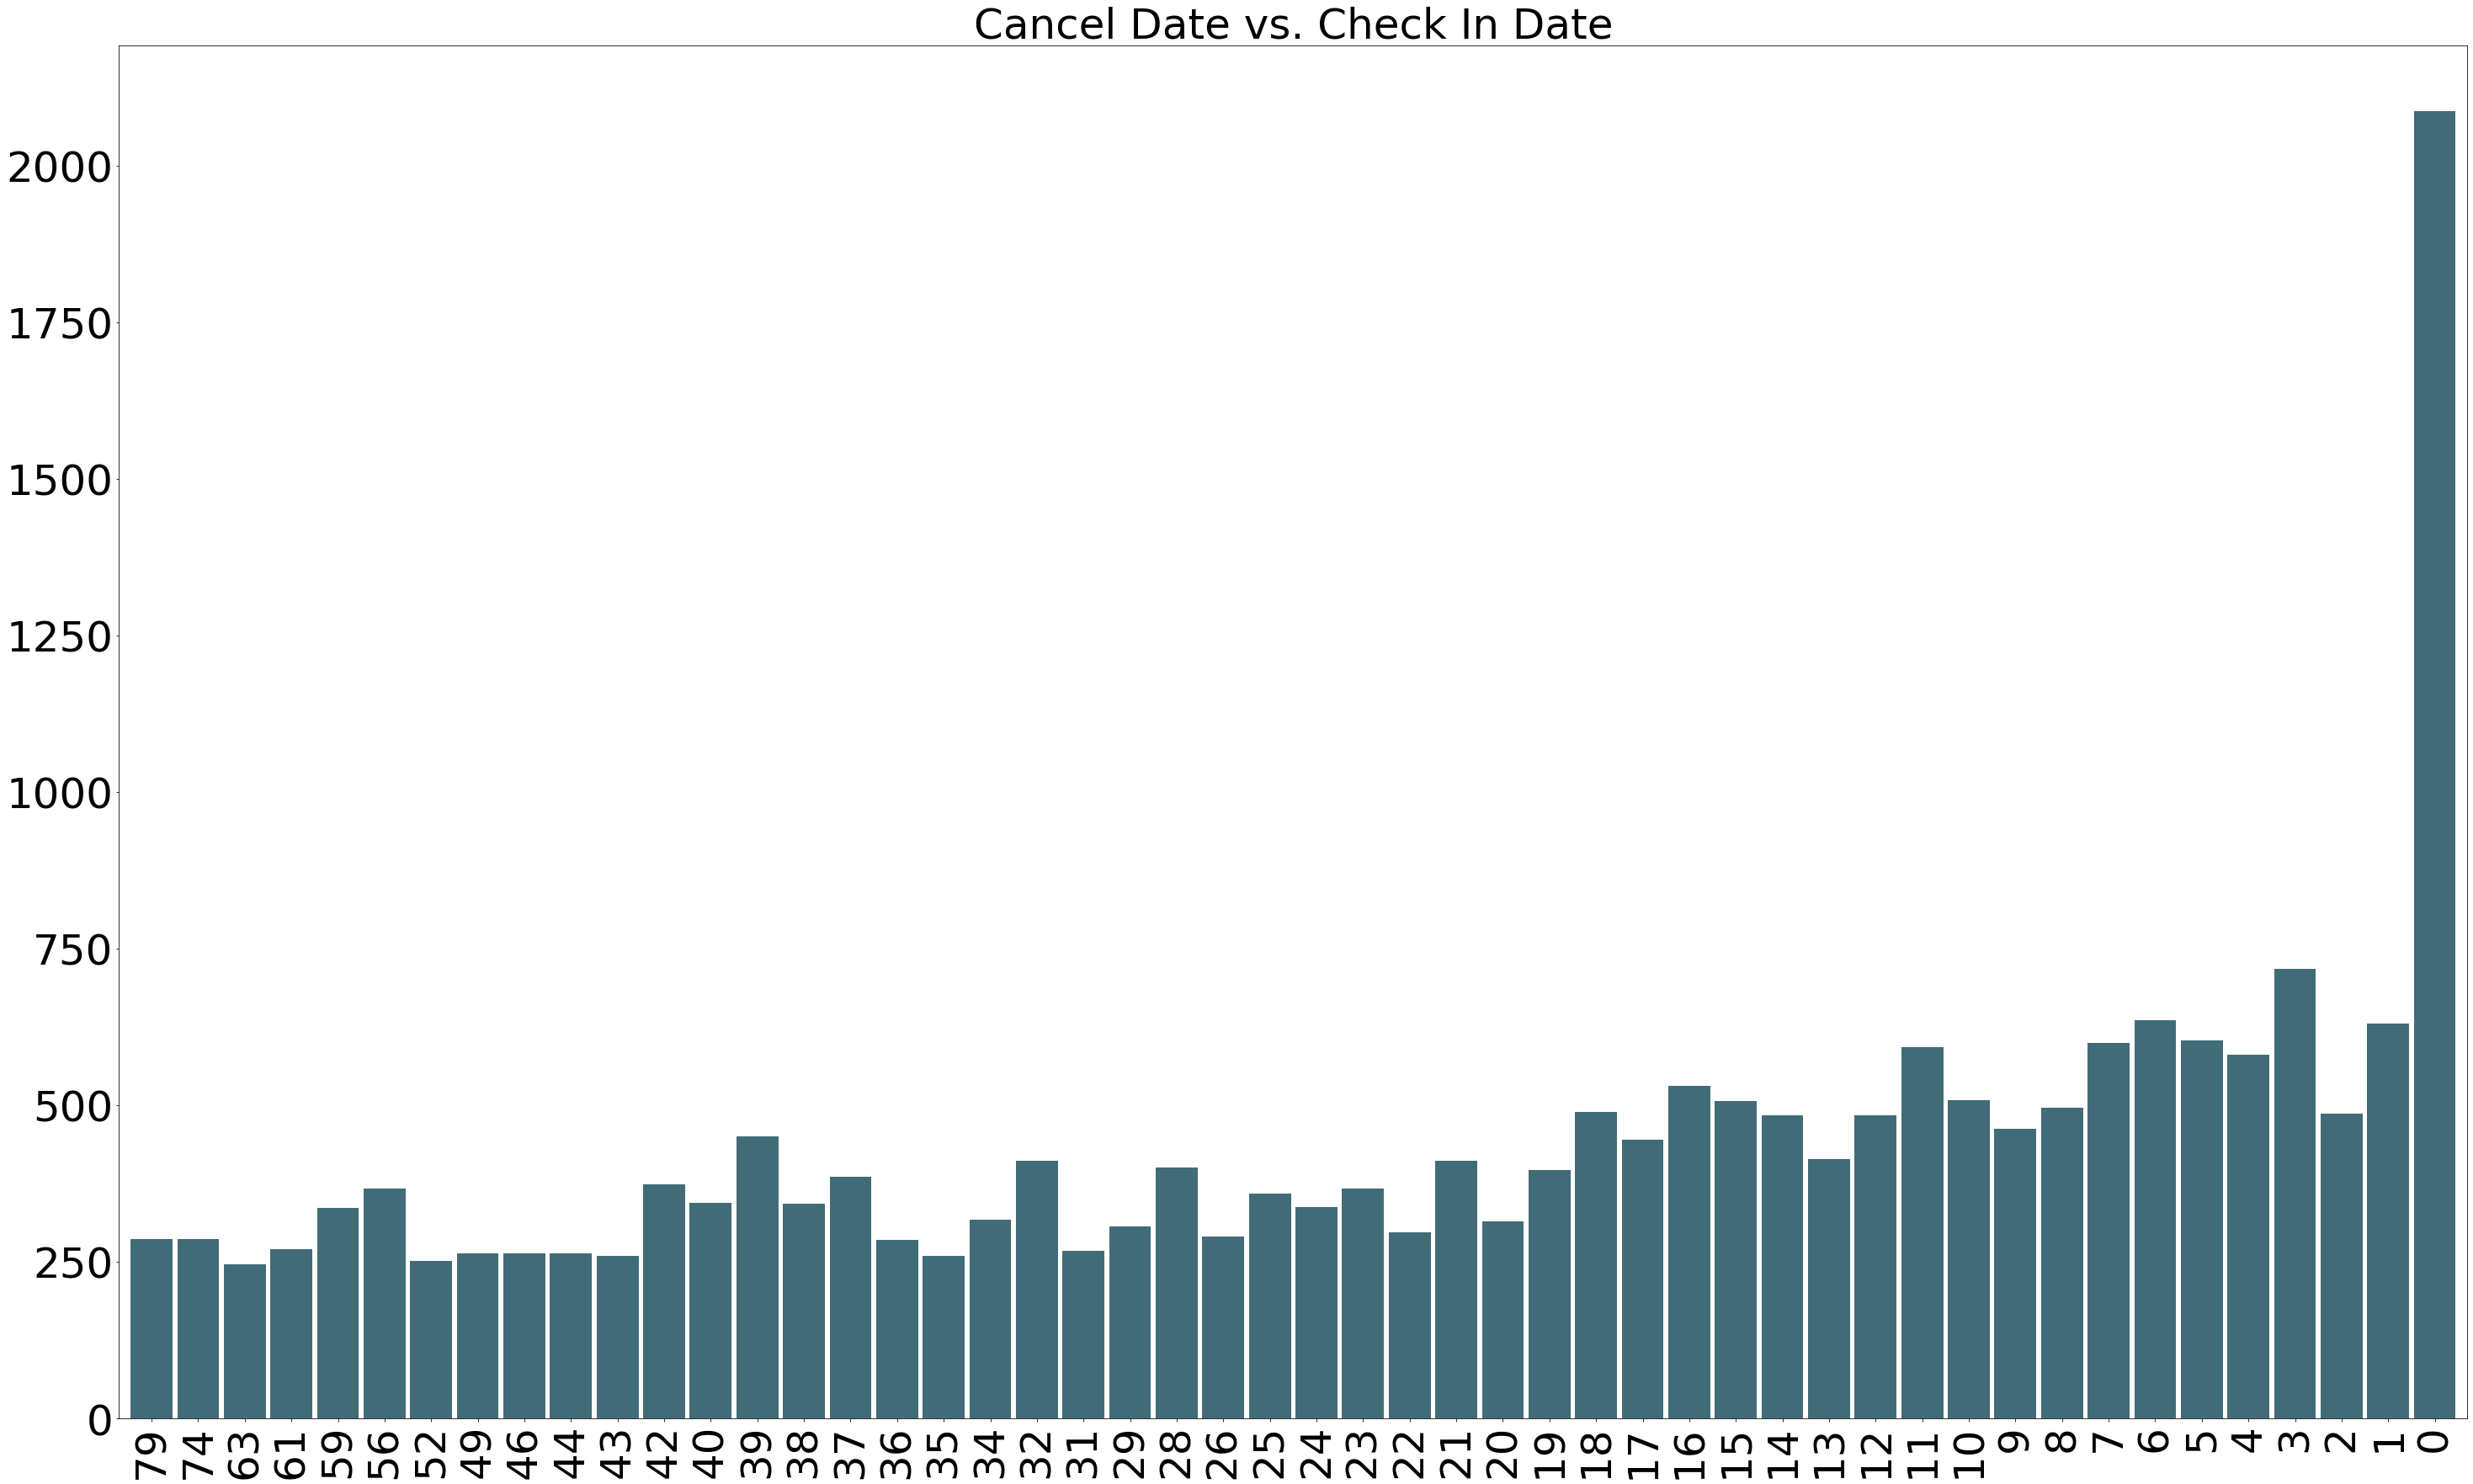

In [16]:
canceled = df.loc[(df["is_canceled"])]
ax = (canceled.arrival_date-canceled.reservation_status_date) \
    .astype('timedelta64[D]') \
    .astype('int') \
    .value_counts() \
    .head(50) \
    .sort_index(ascending=False) \
    .plot(kind="bar", title="Cancel Date vs. Check In Date", **STYLES)
ax.title.set_size(50)

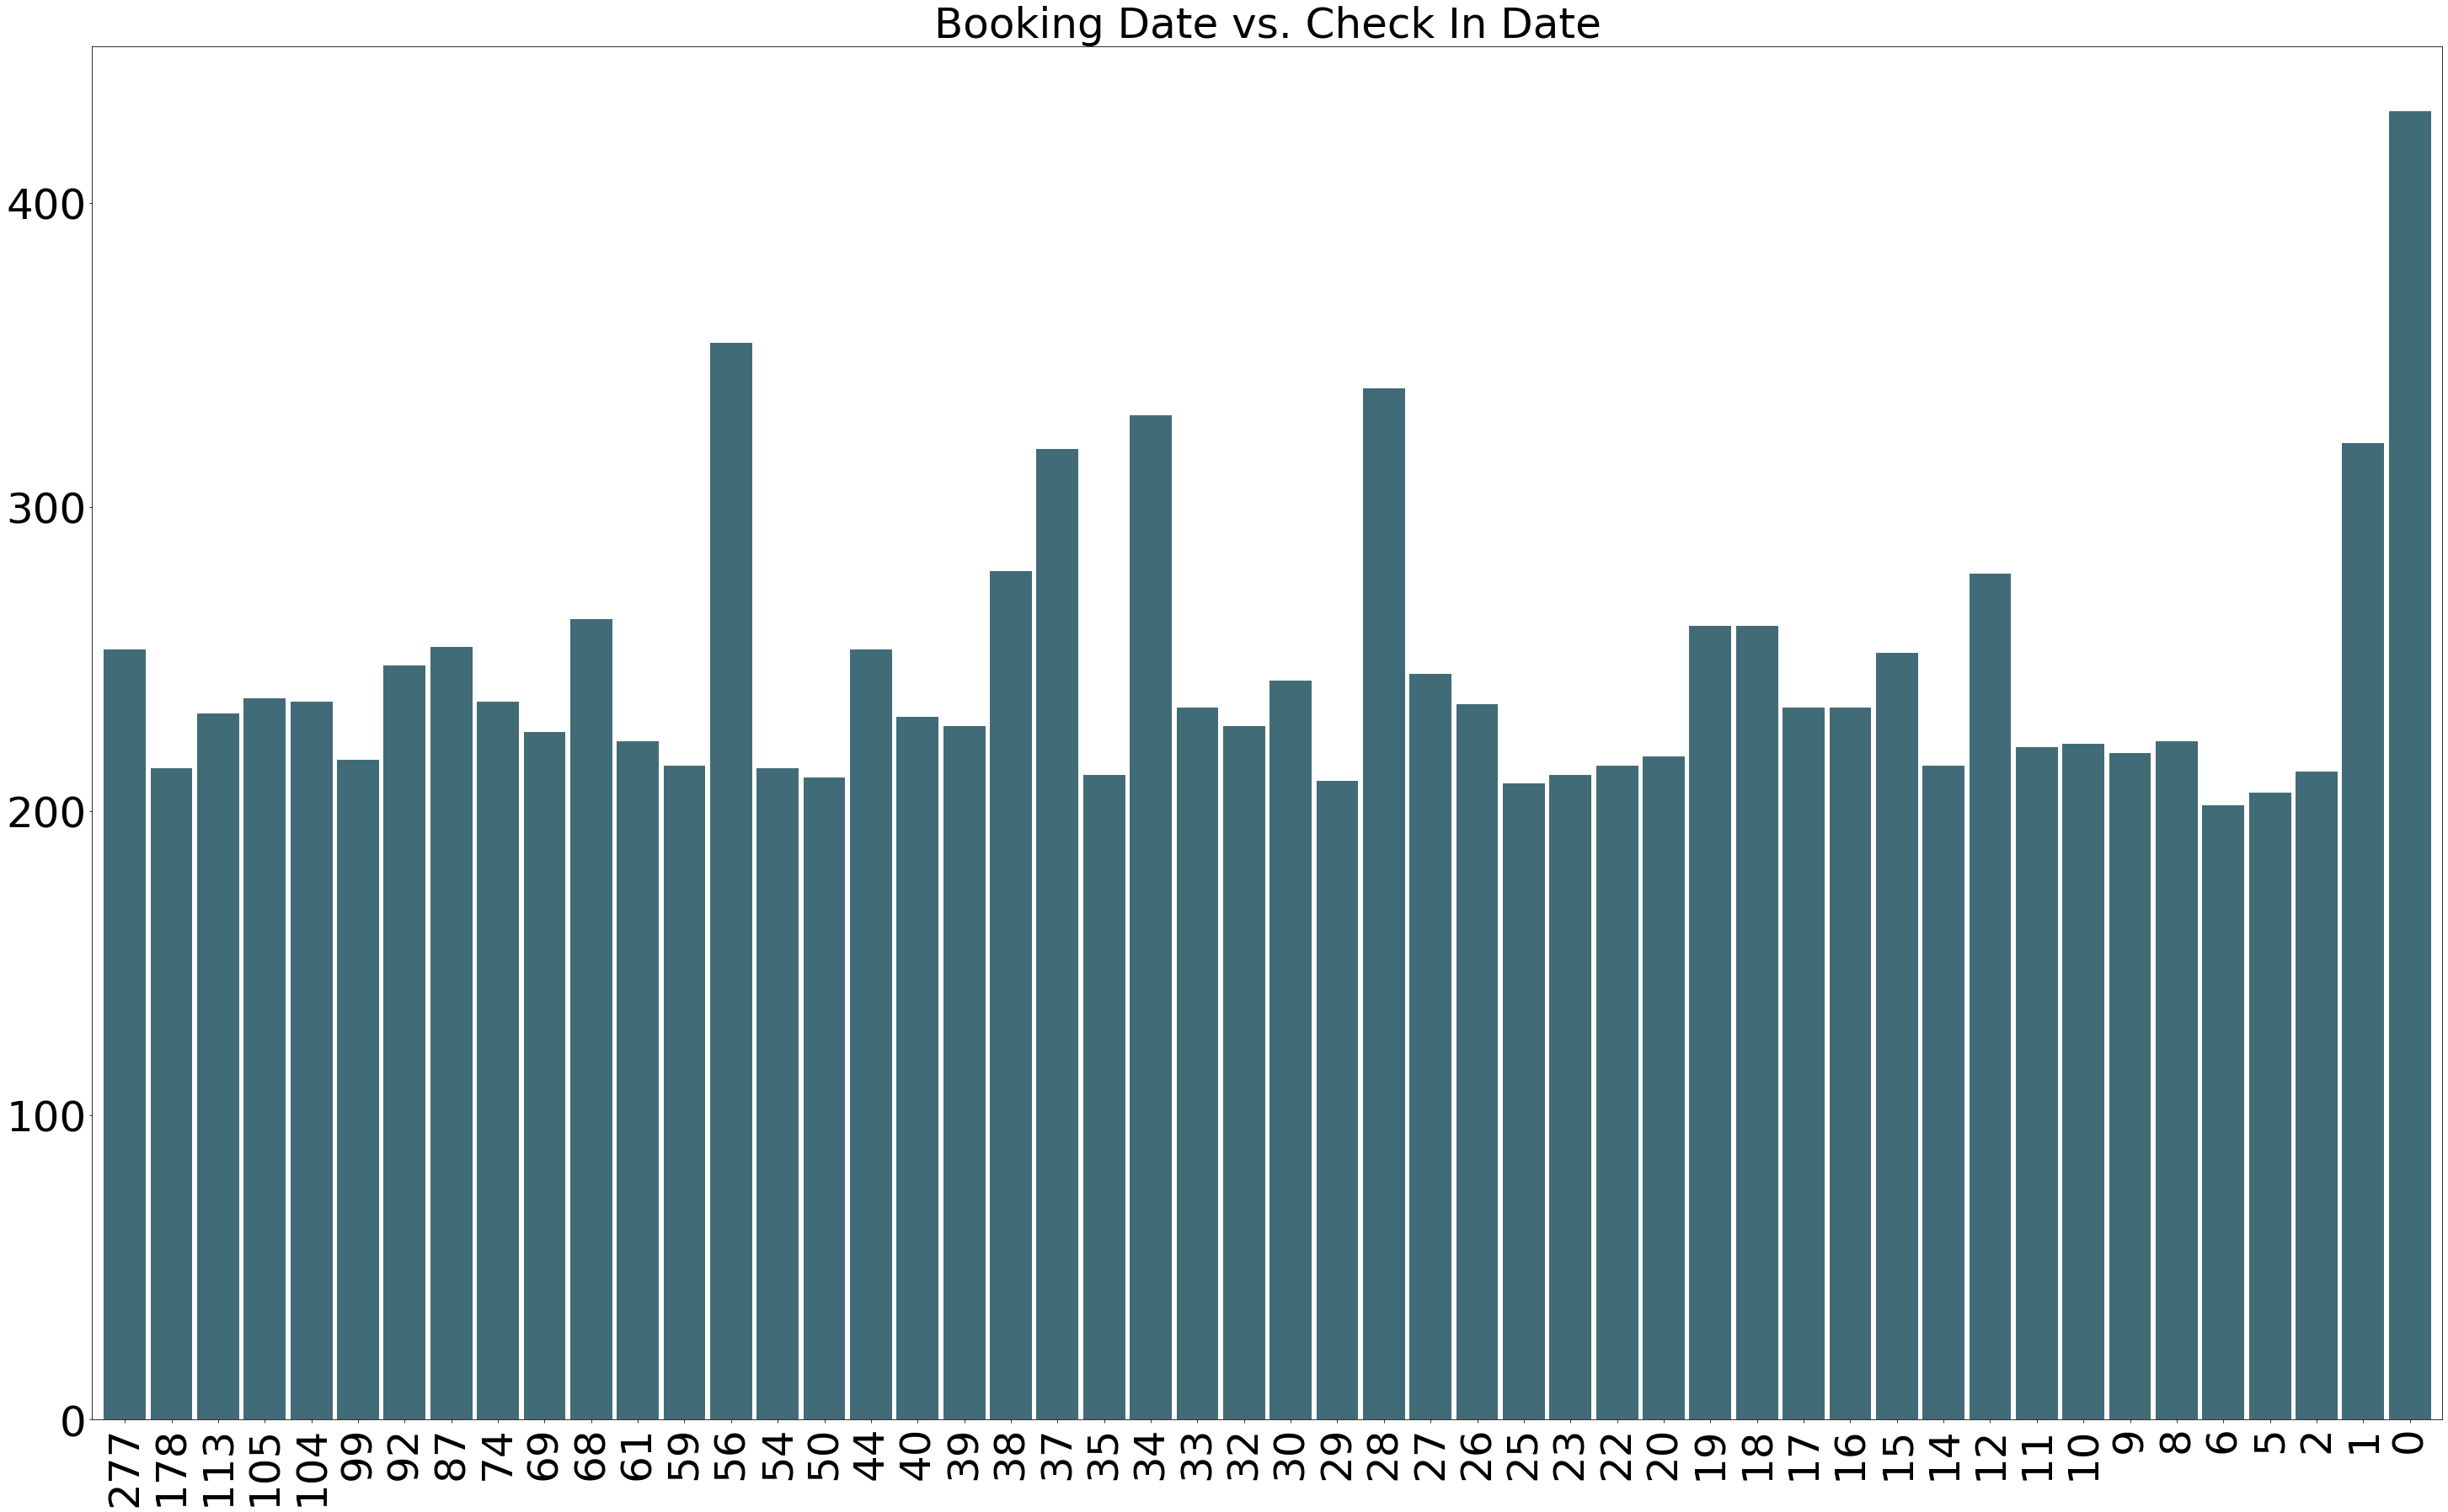

In [17]:
canceled = df.loc[(df["is_canceled"])]
ax = canceled["lead_time"] \
    .astype('int') \
    .value_counts() \
    .head(50) \
    .sort_index(ascending=False) \
    .plot(kind="bar", title="Booking Date vs. Check In Date", **STYLES)
ax.title.set_size(50)

## Reasoning Canceled Booking

In [18]:
# do not split
x = df \
    .drop("is_canceled",axis=1) \
    .drop("reservation_status_No-Show",axis=1) \
    .drop("reservation_status_Canceled",axis=1) \
    .drop("reservation_status_Check-Out",axis=1) \
    .drop("reservation_status_date",axis=1) \
    .drop("previous_bookings_not_canceled",axis=1) \
    .drop("country",axis=1) \
    .drop("arrival_date",axis=1) \
    .drop("arrival_date_day_of_month",axis=1) \
    .drop("arrival_date_month",axis=1) \
    .drop("arrival_date_year",axis=1) \
    .drop("arrival_date_week_number",axis=1) \
    .drop("deposit_type_Refundable",axis=1) \
    .drop("deposit_type_Non Refund",axis=1) \
    .drop("deposit_type_No Deposit",axis=1)
y = df["is_canceled"]

dtree = DecisionTreeClassifier(max_depth=5)
dtree.fit(x,y)
predictions_dctr = dtree.predict(x)
print(classification_report(y,predictions_dctr))

              precision    recall  f1-score   support

       False       0.79      0.88      0.83     75166
        True       0.75      0.60      0.66     44224

    accuracy                           0.78    119390
   macro avg       0.77      0.74      0.75    119390
weighted avg       0.77      0.78      0.77    119390



In [19]:
print(export_text(dtree, feature_names=list(x.columns), show_weights=True))

|--- lead_time <= 24.50
|   |--- lead_time <= 7.50
|   |   |--- required_car_parking_spaces <= 0.50
|   |   |   |--- previous_cancellations <= 0.50
|   |   |   |   |--- total_of_special_requests <= 0.50
|   |   |   |   |   |--- weights: [8856.00, 1309.00] class: False
|   |   |   |   |--- total_of_special_requests >  0.50
|   |   |   |   |   |--- weights: [6045.00, 443.00] class: False
|   |   |   |--- previous_cancellations >  0.50
|   |   |   |   |--- adr <= 89.38
|   |   |   |   |   |--- weights: [282.00, 53.00] class: False
|   |   |   |   |--- adr >  89.38
|   |   |   |   |   |--- weights: [22.00, 97.00] class: True
|   |   |--- required_car_parking_spaces >  0.50
|   |   |   |--- weights: [2639.00, 0.00] class: False
|   |--- lead_time >  7.50
|   |   |--- previous_cancellations <= 0.50
|   |   |   |--- required_car_parking_spaces <= 0.50
|   |   |   |   |--- total_of_special_requests <= 0.50
|   |   |   |   |   |--- weights: [4525.00, 2164.00] class: False
|   |   |   |   |--- t

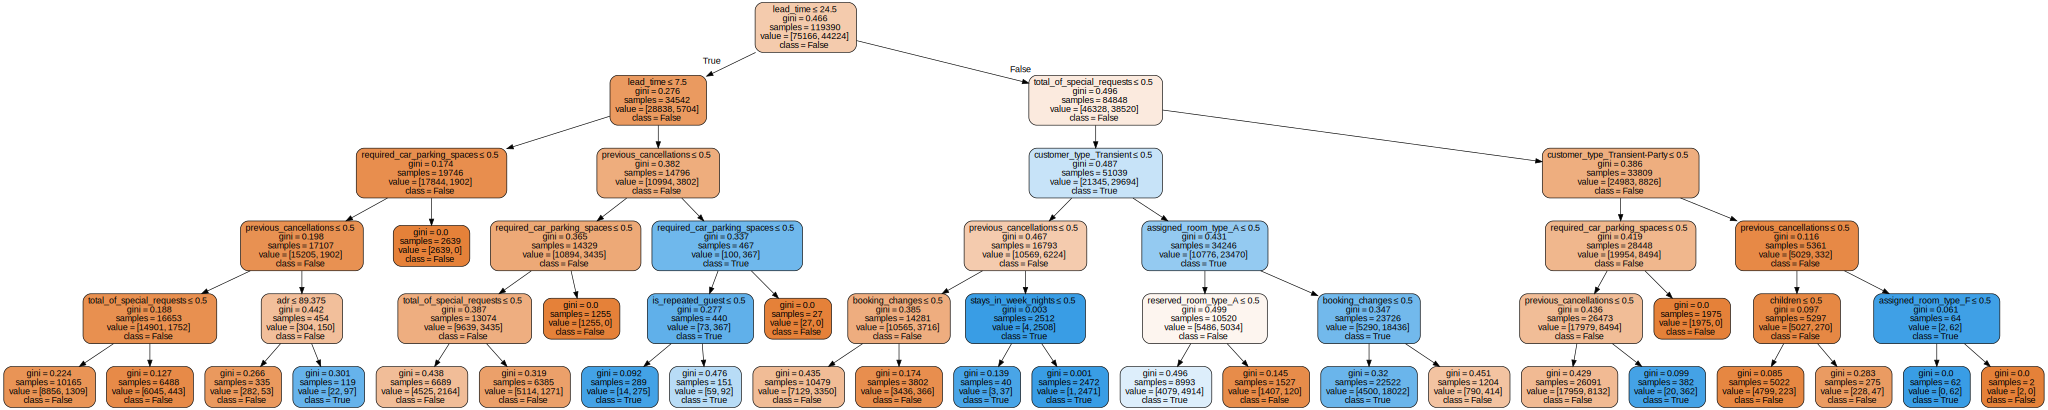

In [20]:
dot_data = export_graphviz(dtree, out_file=None,
                     feature_names=list(x.columns),
                     class_names=["False", "True"],
                     filled=True, rounded=True,
                     special_characters=True)  
graph = graphviz.Source(dot_data, format="png")
graph

## Lead Week and Average Daily Rates

In [21]:
df["lead_time"] = df["lead_time"] // 7

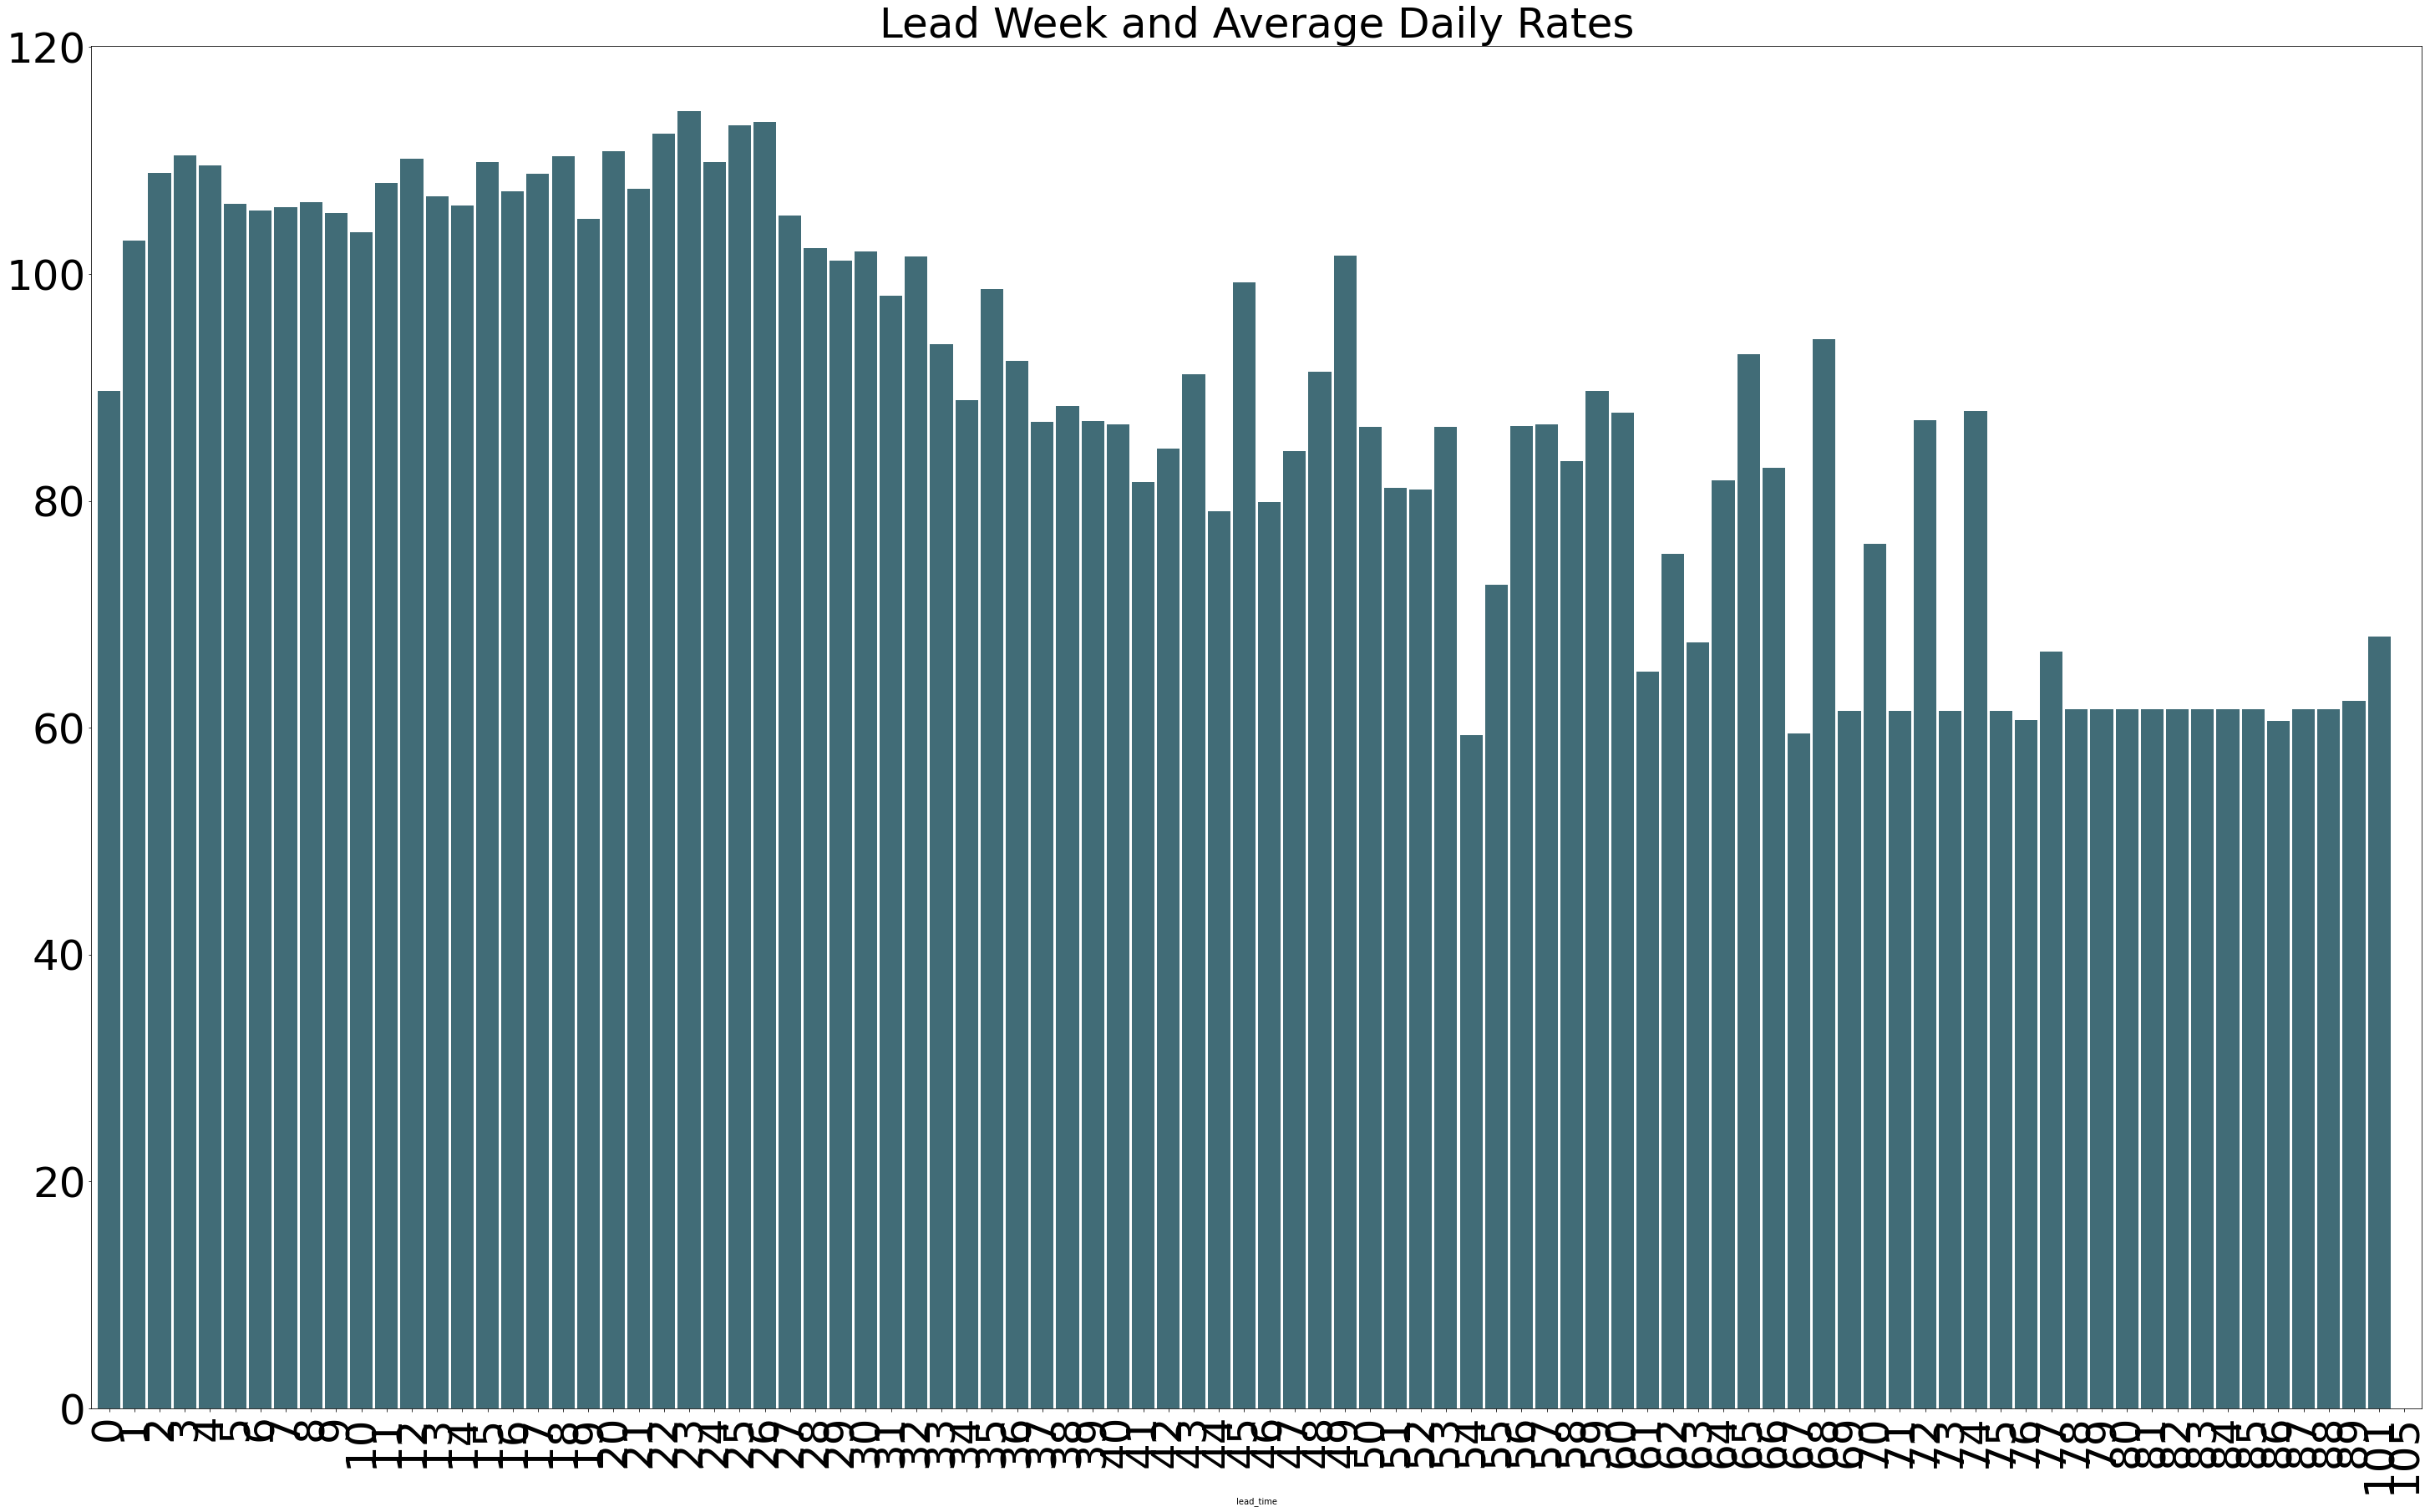

In [22]:
ax = df.groupby("lead_time").mean()["adr"].plot(kind="bar", title="Lead Week and Average Daily Rates", **STYLES)
ax.title.set_size(50)

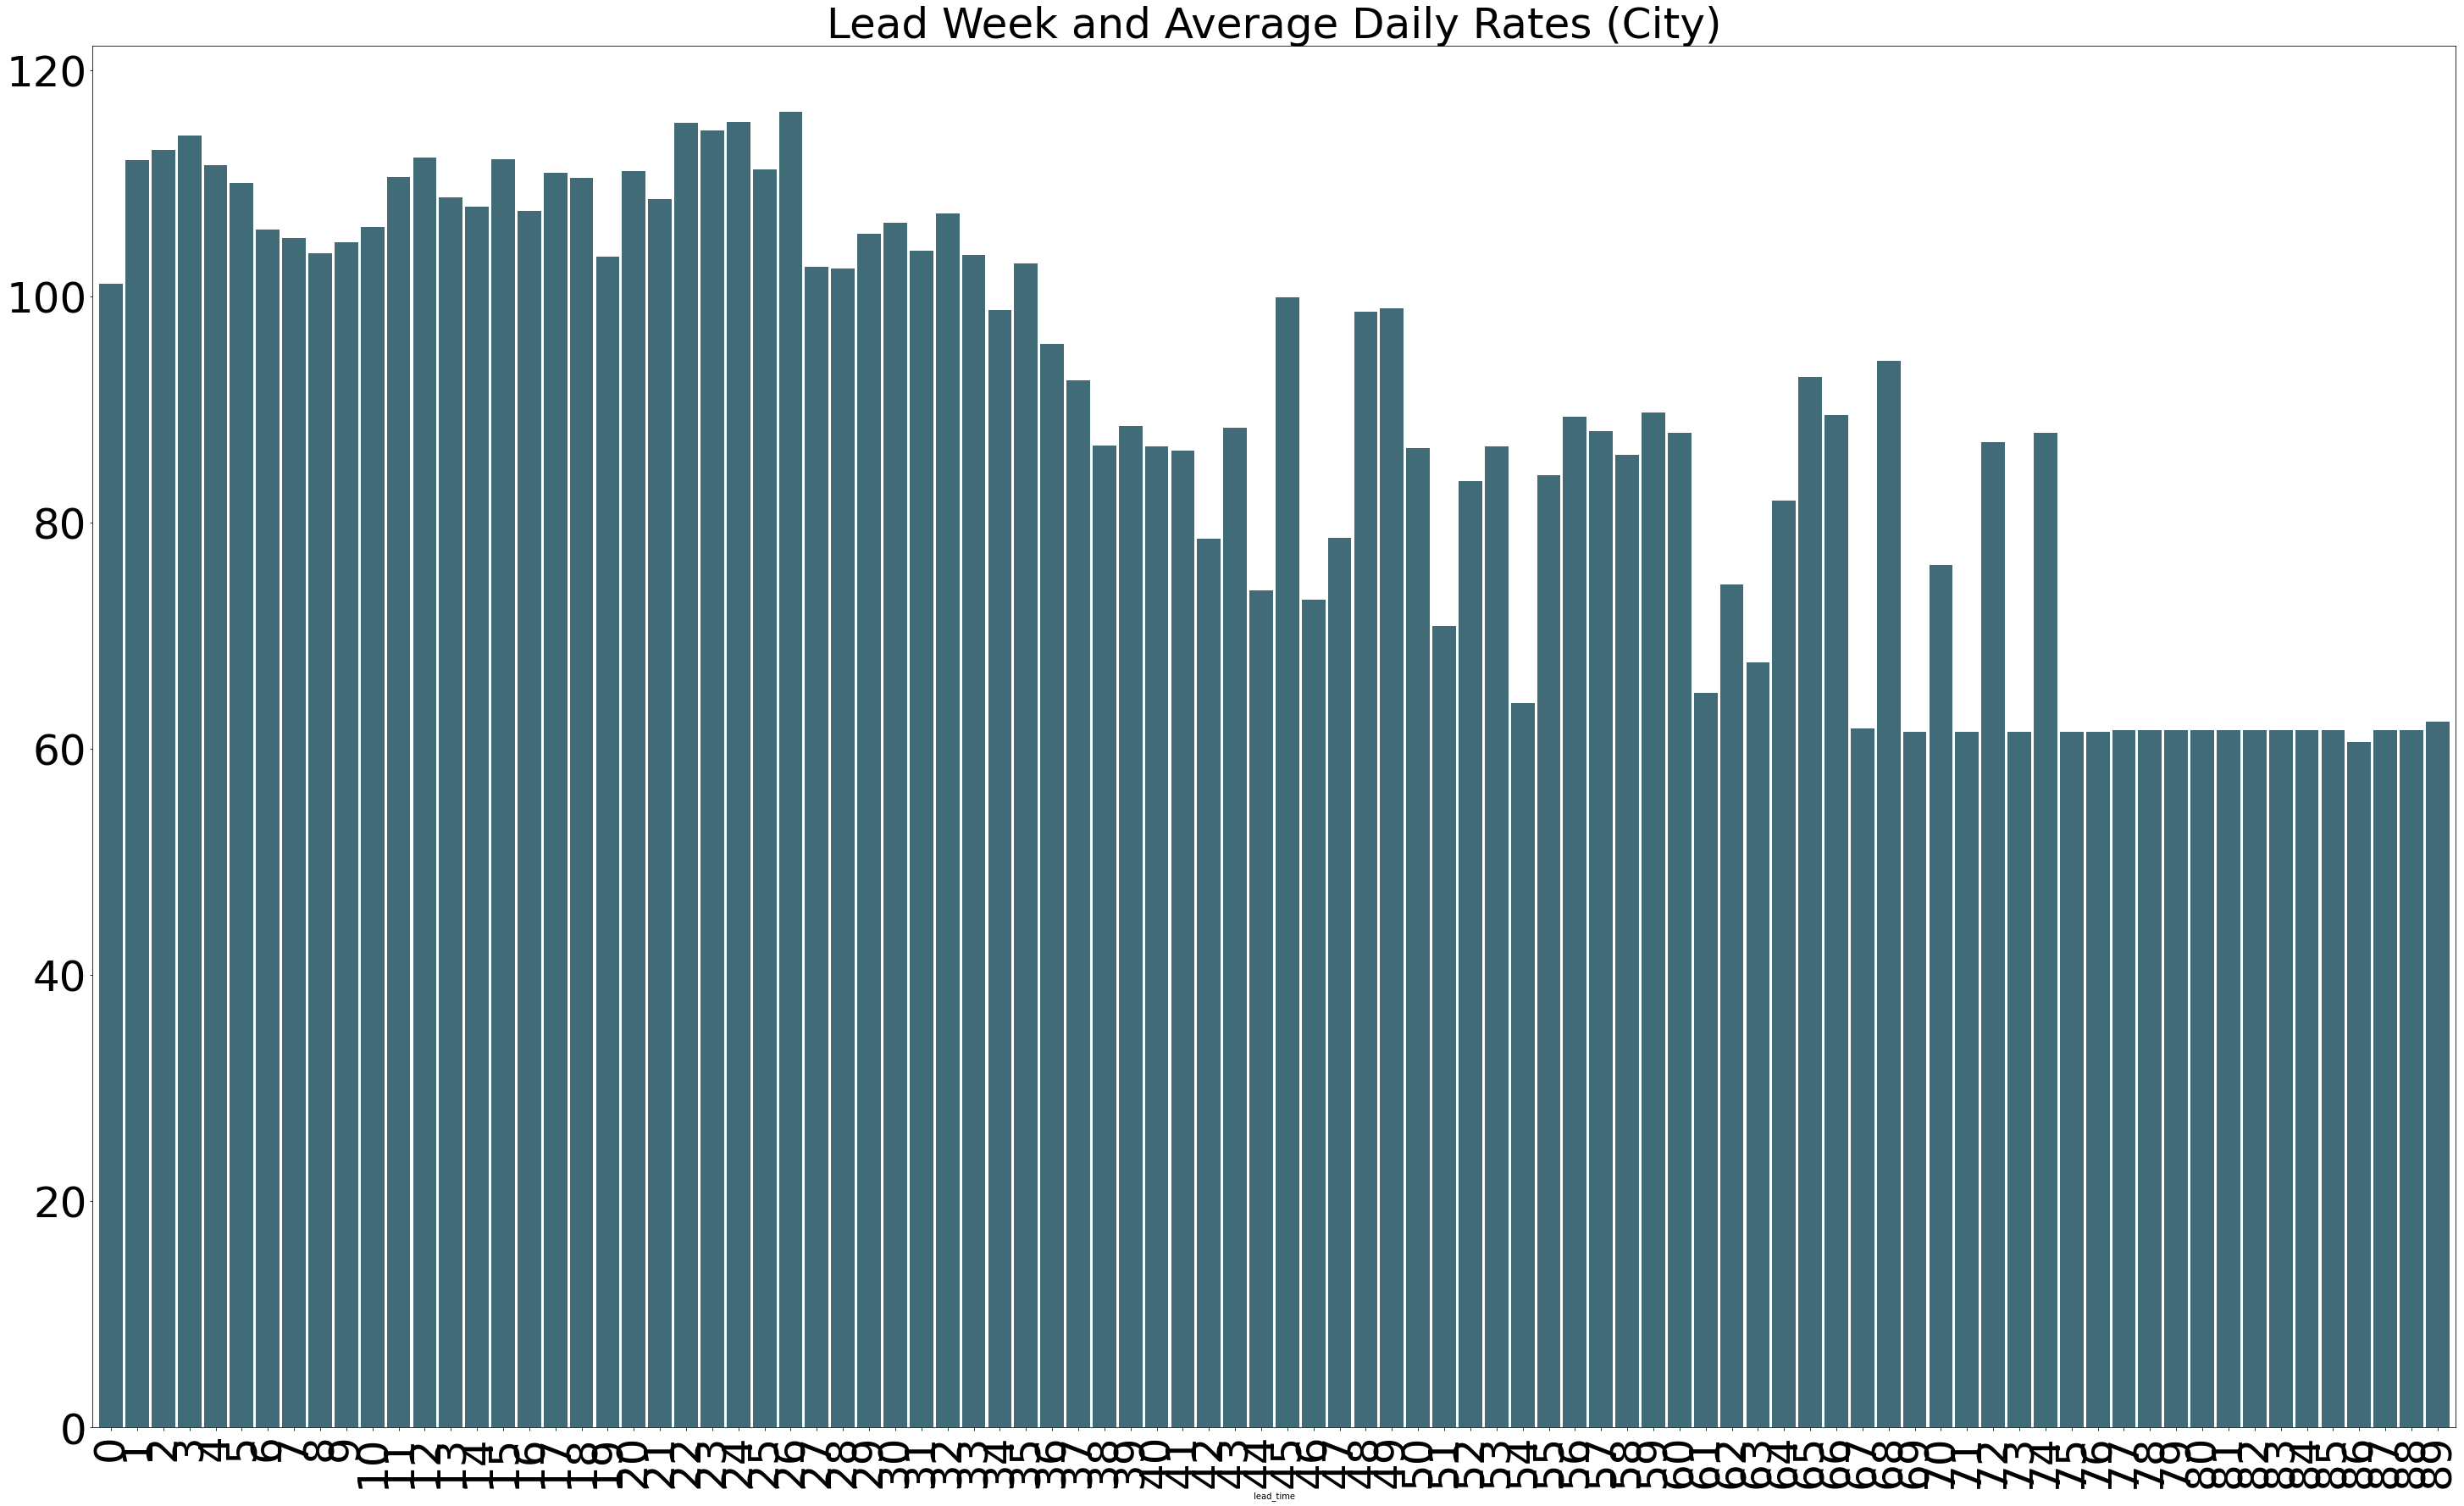

In [23]:
city_df = df.loc[(df["hotel_City Hotel"])]
ax = city_df.groupby("lead_time").mean()["adr"].plot(kind="bar", title="Lead Week and Average Daily Rates (City)", **STYLES)
ax.title.set_size(50)

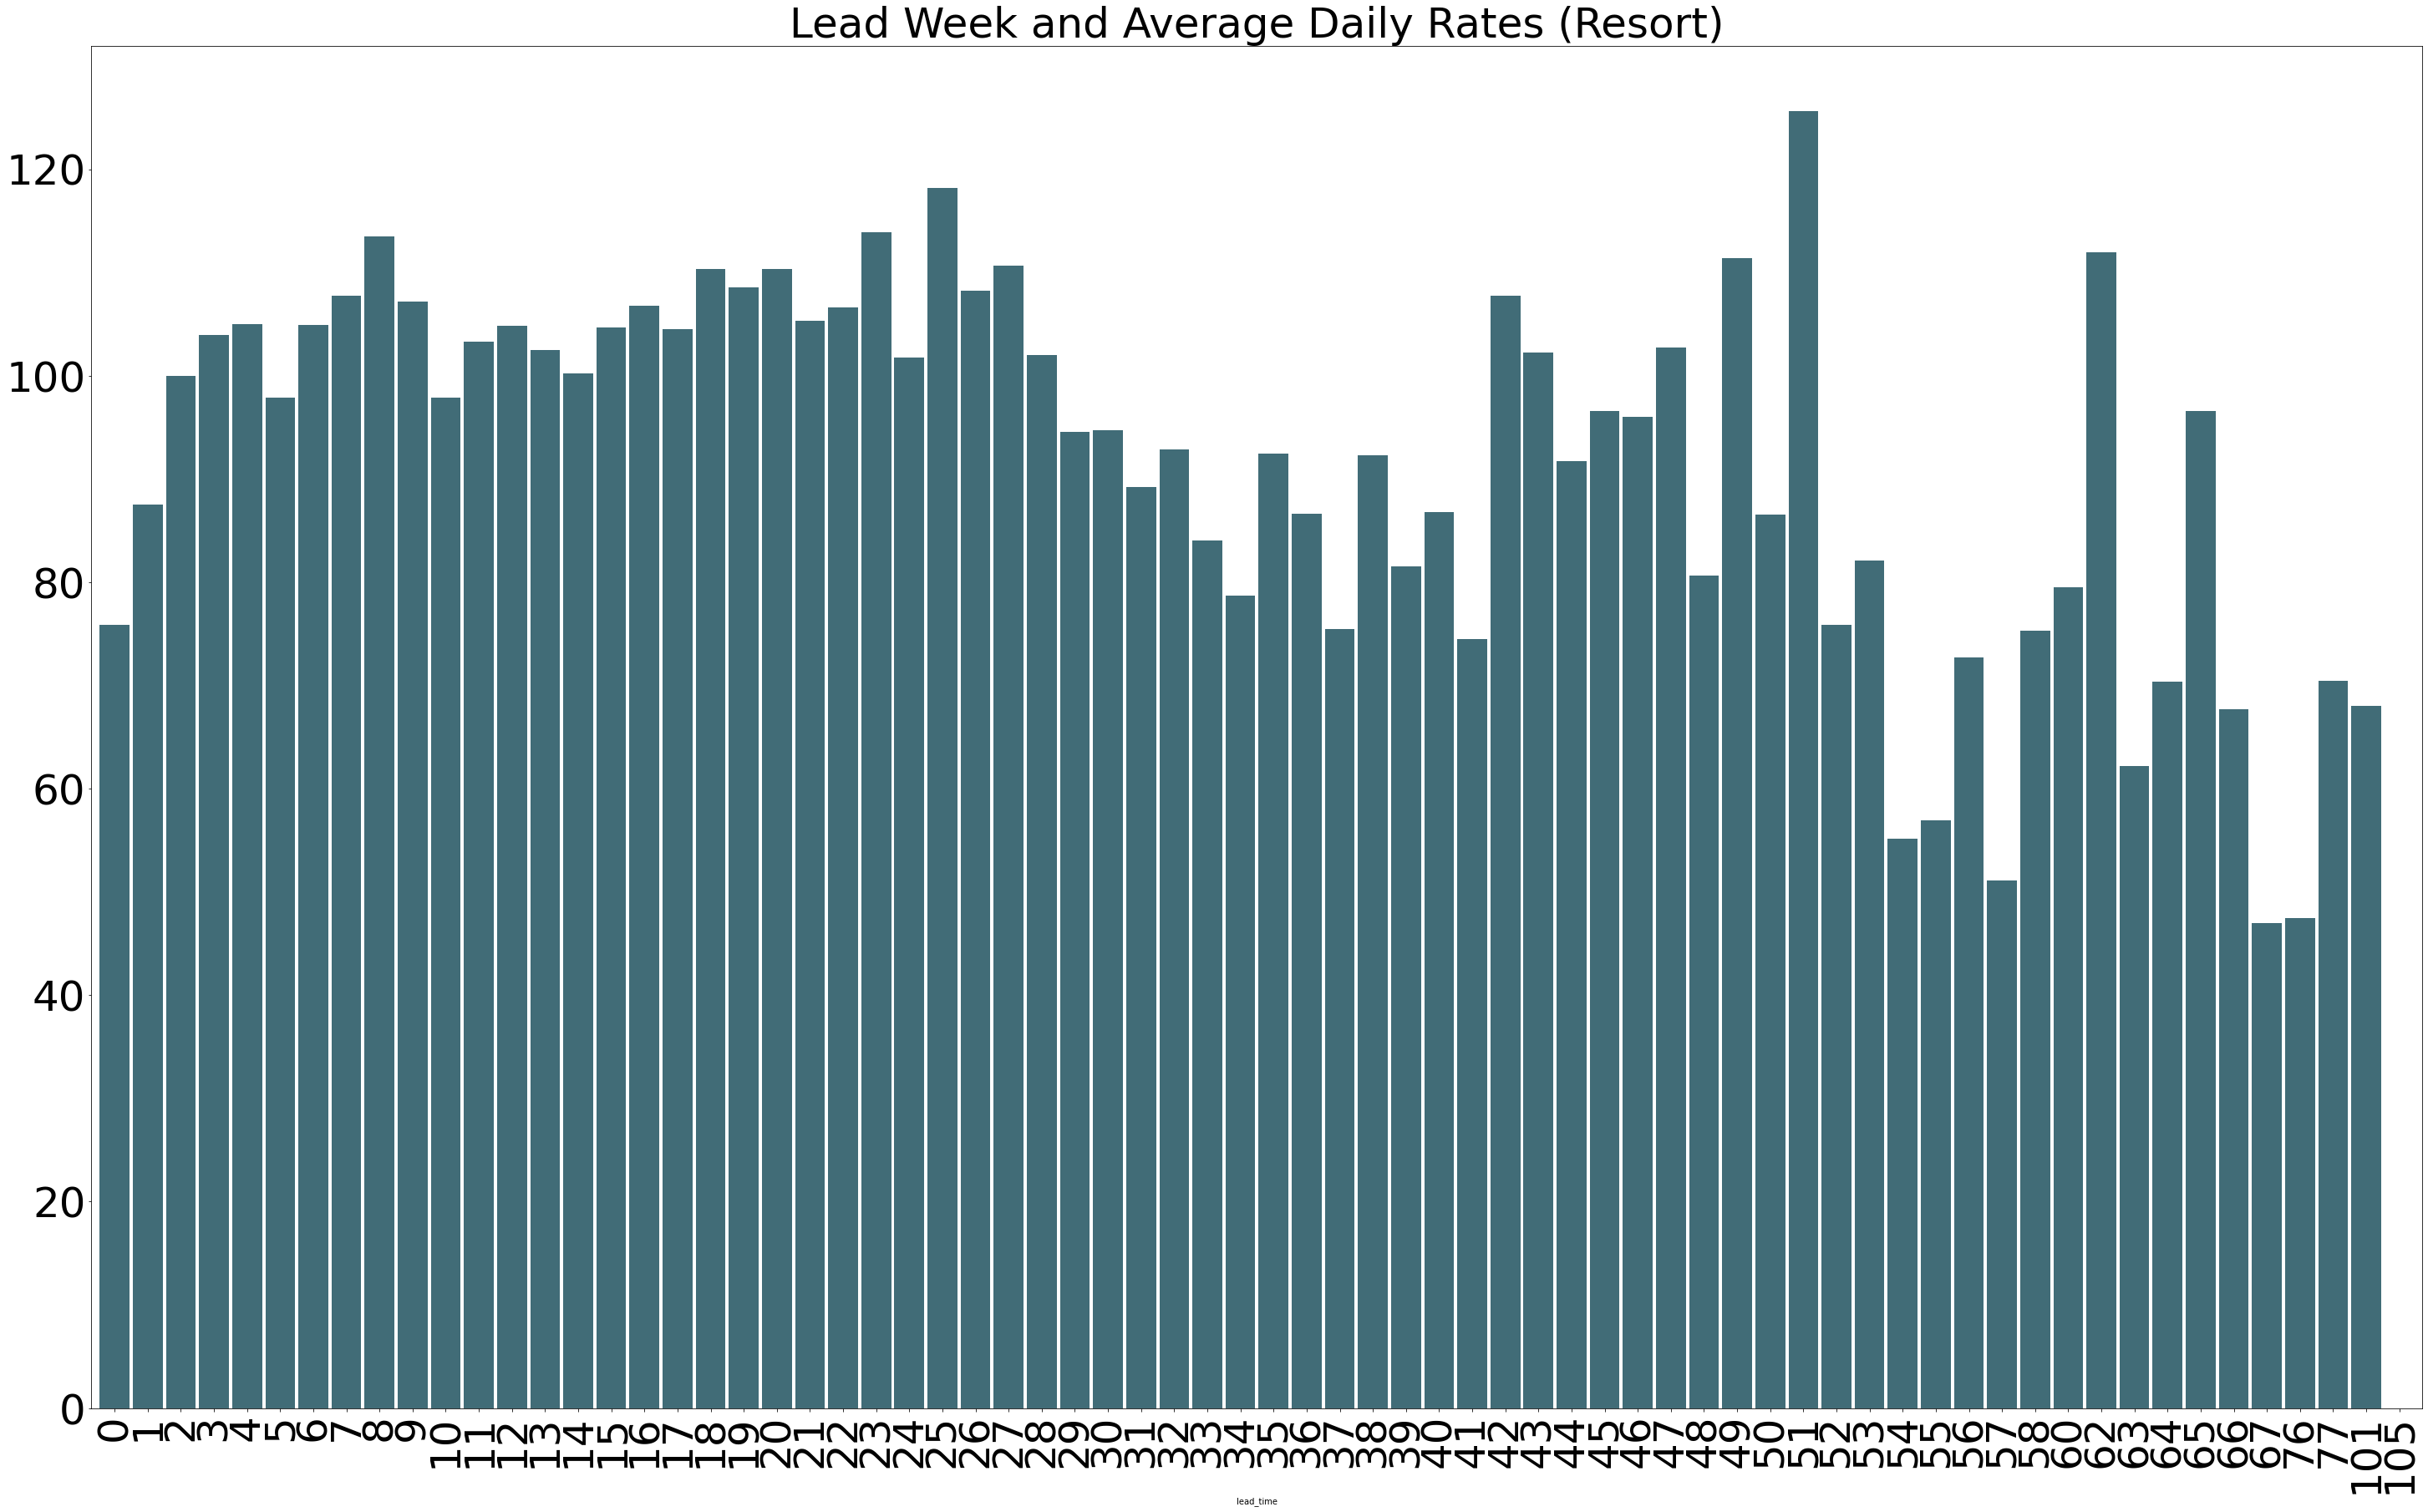

In [24]:
resort_df = df.loc[(df["hotel_Resort Hotel"])]
ax = resort_df.groupby("lead_time").mean()["adr"].plot(kind="bar", title="Lead Week and Average Daily Rates (Resort)", **STYLES)
ax.title.set_size(50)